In [1]:
%load_ext autoreload
%autoreload 2

expt_path = r'T:\jumping_revisions'

# import analyze_movements as am
import os,fnmatch
import shutil
import time
import numpy as np
import numpy.matlib as npm
import csv
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
import analyze_movements as am
import cv2
import imageio
from scipy import signal,stats
import json
from matplotlib.backends.backend_pdf import PdfPages
import pylab
import seaborn as sns
import h5py
from glob import glob
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# from IPython.display import display
# pd.options.display.max_columns = None
pd.set_option('display.max_rows', 20)


### Set general plotting parameters
plt.rcParams.update({'font.size': 12})
plot_params = {'cm':pylab.get_cmap('jet'),
               'pointsize':3,
               'cond_col':['k',[0.6,0.6,0.6]],
               'hmm_col':[[0.6,0.6,0.6], 'k'],
               '4cond_col':[[1,0,0],'k',[0.5,0,0],[0.6,0.6,0.6]],
               'cond_sty':['-',':'],
               '4cond_sty':[':','-',':','-'],
               'plat_cols':['b','r','m'],
               'laser_col':['k','c'],
               'bm_col':['b','m']}

### Chose whether you want to make PDF/videos
save_pdf = True #do you want to save figures to pdf?
show_UMAP = False # do you want to launch the UMAP html visualizer?
make_videos = False #do you want to make videos showing bobs?
pd.set_option('display.max_rows', 20)

#a function to find the files we want
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files: 
            if fnmatch.fnmatch(name,pattern): 
                result.append(os.path.join(root,name))
    if len(result)==1:
        result = result[0]
    return result

print('finished loading dependencies')

finished loading dependencies


# Manual file naming error fixes

In [37]:
### if you need to rename any files, use this code
# expt_path = r'T:\jumping_revisions\030122\PVCHA7LT'
# files = find('*PVCHA7RT*',expt_path)
# for n,f in enumerate(files):
#     os.rename(f,f.replace('PVCHA7RT','PVCHA7LT'))

In [40]:
# def flank_num_w_underscores(nums):
#     # return ['_' + str(n) + 'D' for n in nums]
#     # return ['_' + str(n) + '.' for n in nums]
#     return ['_' + str(n) + '_' for n in nums]

# expt_path = r'T:\jumping_revisions\030122\PVCHA7LT'
# files = find('*PVCHA7LT*',expt_path)
# og_nums = np.arange(30,65)
# og_labels = flank_num_w_underscores(og_nums)
# new_labels = flank_num_w_underscores(np.arange(0,len(og_labels)))
# for f in files:
#     for og,new in zip(og_labels,new_labels):
#         if og in f:
#             os.rename(f,f.replace(og,new))

In [38]:
### binoc = 012922 to 021022
### monoc = 021922 to 022522

### binoc opto = 021122 to 021822
### monoc opto = 022622 to 030222

# Load in the trial metadata and save out a dataframe

In [2]:
expt_path = r'T:\jumping_revisions'
side_pixpercm = 35 #undistorted, raw is 28
top_pixpercm = 21 #raw, no undistortion performed
metadata_file = r'T:\jumping_revisions_analysis\trial_metadata.h5'

data,exptfiles = am.csv_to_df(expt_path,side_pixpercm,top_pixpercm)
data = data[data['subject']!='PVCHA6TT']
data.reset_index(inplace=True,drop=True)
group_label = {'PVCHA6LN':'WT','PVCHA6LT':'WT','PVCHA6RT':'ChR2','PVCHA7LN':'ChR2','PVCHA7LT':'WT','PVCHA7RN':'ChR2','PVCHA7RT':'ChR2','PVCHA7TT':'WT'}
expt_group = []
for index,row in data.iterrows():
    expt_group.append(group_label[row['subject']])
data['expt_group'] = expt_group
print(data.shape)
anis = np.unique(data['subject'])
numAni = len(anis)
print('%d trials/animal' % np.round(data.shape[0]/numAni))
data.head()

# save the data
data.to_hdf(metadata_file,key='df',mode='w')

loading 012922_PVCHA7LN_control
loading 012922_PVCHA7LT_control
loading 012922_PVCHA7RN_control
loading 012922_PVCHA7RT_control
loading 012922_PVCHA7TT_control
loading 013022_PVCHA7LN_control
loading 013022_PVCHA7LT_control
loading 013022_PVCHA7RN_control
loading 013022_PVCHA7RT_control
loading 013022_PVCHA7TT_control
loading 013122_PVCHA7LN_control
loading 013122_PVCHA7LT_control
loading 013122_PVCHA7RN_control
loading 013122_PVCHA7RT_control
loading 013122_PVCHA7TT_control
loading 020122_PVCHA6LN_control
loading 020122_PVCHA6LT_control
loading 020122_PVCHA7LN_control
loading 020122_PVCHA7LT_control
loading 020122_PVCHA7RN_control
loading 020122_PVCHA7RT_control
loading 020122_PVCHA7TT_control
loading 020222_PVCHA6LN_control
loading 020222_PVCHA6LT_control
loading 020222_PVCHA7LN_control
loading 020222_PVCHA7LT_control
loading 020222_PVCHA7RN_control
loading 020222_PVCHA7RT_control
loading 020222_PVCHA7TT_control
loading 020322_PVCHA6LN_control
loading 020322_PVCHA6LT_control
loading 

,trial,success,platform,distance,expdate,subject,condition,laser_trial,fps,Top_pixpercm,Side_pixpercm,ocular,Top_Start,Top_Jump,Top_End,Side_Start,Side_Jump,Side_End,expt_group
0,1,1,2,18,012922,PVCHA7LN,control,0,99.97,21,35,binocular,26.0,360.0,386.0,26.0,360.0,386.0,ChR2
1,2,1,1,18,012922,PVCHA7LN,control,0,99.97,21,35,binocular,34.0,284.0,314.0,34.0,284.0,314.0,ChR2
2,3,2,1,16,012922,PVCHA7LN,control,0,99.97,21,35,binocular,42.0,242.0,266.0,42.0,242.0,266.0,ChR2
3,4,1,1,20,012922,PVCHA7LN,control,0,99.97,21,35,binocular,45.0,499.0,525.0,44.0,498.0,524.0,ChR2
4,5,1,1,22,012922,PVCHA7LN,control,0,99.97,21,35,binocular,46.0,240.0,266.0,46.0,240.0,266.0,ChR2


# Incoroporate side cam DLC points into dataframe and save out

In [471]:
# load metadata
metadata_file = r'T:\jumping_revisions_analysis\trial_metadata.h5'
data = pd.read_hdf(metadata_file,key='df')

In [472]:
data.shape

(8814, 19)

In [8]:
# if deltaFrameNum=0 for any of the three trial events (happens with aborts usually), add 100 frames so the code doesn't error out
for index,row in data.iterrows():
    if row['Top_End']==row['Top_Jump']:
        data['Top_End'].iloc[index] = row['Top_Jump'] + 100
        data['Side_End'].iloc[index] = row['Side_Jump'] + 100
        print('fixed %s %s %d' % (row['expdate'], row['subject'], row['trial']))
    if row['Top_Jump']==row['Top_Start']:
        data['Top_Jump'].iloc[index] = row['Top_Start'] + 100
        data['Side_Jump'].iloc[index] = row['Side_Start'] + 100
        print('fixed %s %s %d' % (row['expdate'], row['subject'], row['trial']))


fixed 020222 PVCHA7LN 8


In [473]:
# find DLC files
dlc_path = 'T:\jumping_revisions'
dlc_files = am.find('*filtered.h5',dlc_path)
print('%d total DLC trials' % (len(dlc_files)/2))

8866 total DLC trials


In [10]:
# add DLC data to dataframe for side cam only
lh_thresh = 0.95
filtered=True
df_all = am.load_dlc_h5_decision_period_only_revisions(data,['Side'],dlc_path,lh_thresh)

data_file = r'T:\jumping_revisions_analysis\df_decision_alldata_side.h5'
df_all.to_hdf(data_file,key='df',mode='w')

trying 012922_PVCHA7LN_control_0
trying 012922_PVCHA7LN_control_1
trying 012922_PVCHA7LN_control_2
trying 012922_PVCHA7LN_control_3
trying 012922_PVCHA7LN_control_4
trying 012922_PVCHA7LN_control_5
trying 012922_PVCHA7LN_control_6
trying 012922_PVCHA7LN_control_7
trying 012922_PVCHA7LN_control_8
trying 012922_PVCHA7LN_control_9
trying 012922_PVCHA7LN_control_10
trying 012922_PVCHA7LN_control_11
trying 012922_PVCHA7LN_control_12
trying 012922_PVCHA7LN_control_13
trying 012922_PVCHA7LN_control_14
trying 012922_PVCHA7LN_control_15
trying 012922_PVCHA7LN_control_16
trying 012922_PVCHA7LN_control_17
trying 012922_PVCHA7LN_control_18
trying 012922_PVCHA7LN_control_19
trying 012922_PVCHA7LN_control_20
trying 012922_PVCHA7LN_control_21
trying 012922_PVCHA7LN_control_22
trying 012922_PVCHA7LN_control_23
trying 012922_PVCHA7LN_control_24
trying 012922_PVCHA7LN_control_25
trying 012922_PVCHA7LN_control_26
trying 012922_PVCHA7LN_control_27
trying 012922_PVCHA7LN_control_28
trying 012922_PVCHA7LN_c

In [477]:
# add DLC data to dataframe for top cam only
lh_thresh = 0.95
filtered=True
df_all = am.load_dlc_h5_decision_period_only_revisions(data,['Top'],dlc_path,lh_thresh)

data_file = r'T:\jumping_revisions_analysis\df_decision_alldata_top.h5'
df_all.to_hdf(data_file,key='df',mode='w')

trying 012922_PVCHA7LN_control_0
trying 012922_PVCHA7LN_control_1
trying 012922_PVCHA7LN_control_2
trying 012922_PVCHA7LN_control_3
trying 012922_PVCHA7LN_control_4
trying 012922_PVCHA7LN_control_5
trying 012922_PVCHA7LN_control_6
trying 012922_PVCHA7LN_control_7
trying 012922_PVCHA7LN_control_8
trying 012922_PVCHA7LN_control_9
trying 012922_PVCHA7LN_control_10
trying 012922_PVCHA7LN_control_11
trying 012922_PVCHA7LN_control_12
trying 012922_PVCHA7LN_control_13
trying 012922_PVCHA7LN_control_14
trying 012922_PVCHA7LN_control_15
trying 012922_PVCHA7LN_control_16
trying 012922_PVCHA7LN_control_17
trying 012922_PVCHA7LN_control_18
trying 012922_PVCHA7LN_control_19
trying 012922_PVCHA7LN_control_20
trying 012922_PVCHA7LN_control_21
trying 012922_PVCHA7LN_control_22
trying 012922_PVCHA7LN_control_23
trying 012922_PVCHA7LN_control_24
trying 012922_PVCHA7LN_control_25
trying 012922_PVCHA7LN_control_26
trying 012922_PVCHA7LN_control_27
trying 012922_PVCHA7LN_control_28
trying 012922_PVCHA7LN_c

In [11]:
# correct jump distance based on start position, calculate actual gap distance and accuracy
jd_sub = []
actual_distance = []
for idx,row in df_all.iterrows():
    TakeFL_x = np.nanmedian(row['Top TakeFL x'])
    LandFR_x = np.nanmedian(row['Top LandFR x'])
    LandFL_x = np.nanmedian(row['Top LandFL x'])
    actual_distance.append((TakeFL_x - np.nanmean([LandFR_x,LandFL_x]))/row['Top_pixpercm'])
    
    jd_sub.append((row['Top TakeFL x'][-1] - row['Top LEye x'][-1])/row['Top_pixpercm'])
df_all['actual_distance'] = actual_distance
df_all['jumpdist'] = df_all['jumpdist'] + jd_sub
df_all = am.get_jump_accuracy(df_all)

KeyError: 'Top TakeFL x'

In [12]:
# # save the data
data_file = r'T:\jumping_revisions_analysis\df_sideDLCpts.h5'

# save out just the eye/nose/whiskpad, take/land platform edges
# df = df_all[['expdate','subject','condition','platform','distance','jumpdist','success','laser_trial','trial','fps',
#              'Top_pixpercm','Side_pixpercm','ocular','Side_Start','Side_Jump','Top_Start','Top_Jump',
#              'Side Nose x','Top Nose x','Side Nose y','Top Nose y','Side Nose likelihood','Top Nose likelihood',
#              'Side WiskPad x','Top WiskPad x','Side WiskPad y','Top WiskPad y','Side WiskPad likelihood','Top WiskPad likelihood',
#              'Side LEye x','Top LEye x','Side LEye y','Top LEye y','Side LEye likelihood','Top LEye likelihood',
#              'Side LEar x','Top LEar x','Side LEar y','Top LEar y','Side LEar likelihood','Top LEar likelihood',
#              'Side TakeFL x','Top TakeFL x','Side TakeFL y','Top TakeFL y','Side TakeFL likelihood','Top TakeFL likelihood',
#              'Side LandFR x','Top LandFR x','Side LandFR y','Top LandFR y','Side LandFR likelihood','Top LandFR likelihood',
#              'Side LandFL x','Top LandFL x','Side LandFL y','Top LandFL y','Side LandFL likelihood','Top LandFL likelihood']].copy()

df_all.to_hdf(data_file,key='df',mode='w')
# for i in range(len(df_all)):
#     sr = df_all.loc[i] #pandas series object for the given index
#     sr.to_hdf('df.h5', key='table_%i'%i, complib='blosc:lz4', mode='a')

In [443]:
[key for key in df_all.keys()]

['trial',
 'success',
 'platform',
 'distance',
 'expdate',
 'subject',
 'condition',
 'laser_trial',
 'fps',
 'Top_pixpercm',
 'Side_pixpercm',
 'ocular',
 'Top_Start',
 'Top_Jump',
 'Top_End',
 'Side_Start',
 'Side_Jump',
 'Side_End',
 'expt_group',
 'Side Nose x',
 'Side Nose y',
 'Side Nose likelihood',
 'Side WiskPad x',
 'Side WiskPad y',
 'Side WiskPad likelihood',
 'Side LEye x',
 'Side LEye y',
 'Side LEye likelihood',
 'Side LEar x',
 'Side LEar y',
 'Side LEar likelihood',
 'Side TailBase x',
 'Side TailBase y',
 'Side TailBase likelihood',
 'Side MidTail x',
 'Side MidTail y',
 'Side MidTail likelihood',
 'Side TailTip x',
 'Side TailTip y',
 'Side TailTip likelihood',
 'Side TakeFL x',
 'Side TakeFL y',
 'Side TakeFL likelihood',
 'Side TakeFR x',
 'Side TakeFR y',
 'Side TakeFR likelihood',
 'Side LandFL x',
 'Side LandFL y',
 'Side LandFL likelihood',
 'Side LandFR x',
 'Side LandFR y',
 'Side LandFR likelihood',
 'jumpdist']

# load side data

In [110]:
data_file = r'T:\jumping_revisions_analysis\df_sideDLCpts.h5'

df_all = pd.read_hdf(data_file,key='df')
df_all.shape

(8814, 53)

# run top analysis first to correct distance/platform labels (see below), then apply them here

In [619]:
df_all['distance_DLC'] = D
df_all['platform_DLC'] = P

df_all['platform_DLC'] = df_all['platform_DLC'].replace([16,21,22,26],[15,20,25,25])
df_all['platform_DLC'] = df_all['platform_DLC'].replace([15,20,25],[1,2,3])

df_all['distance_DLC'] = df_all['distance_DLC'].replace([4,11,13,15,17,19,21,23,24],[22,10,12,14,16,18,20,22,22])

# ### remove these (bad trials)
to_remove = np.where((df_all['platform_DLC']==0).tolist()|(df_all['distance_DLC']==0)|(df_all['distance_DLC']==5))[0].tolist()
# to_remove = np.where((df_all['platform_DLC']==0)|(df_all['platform_DLC']==22)|(df_all['distance_DLC']==0)|(df_all['distance_DLC']==5)|(df_all['distance_DLC']==4))[0]
df_all = df_all.drop(to_remove)
df_all.reset_index(inplace=True,drop=True)

### get jump accuracy
df_all = am.get_jump_accuracy(df_all)

print(np.unique(df_all['platform_DLC']),np.unique(df_all['distance_DLC']))
print(len(df_jump),len(df_all))

ValueError: Length of values (8814) does not match length of index (8797)

In [626]:
df_all['platform_DLC'].iloc[np.where(df_all['platform_DLC']==22)[0][0]]=3
df_all['distance_DLC'].iloc[np.where(df_all['distance_DLC']==4)[0][0]]=22

In [628]:
df_all['accuracy'] = df_jump_temp['accuracy']
df_all['accuracy']

0        0.526861
1        0.543695
2       20.657019
3        0.836125
4        1.901294
          ...    
8792     0.020304
8793     2.579266
8794     0.536582
8795     1.647477
8796     2.236022
Name: accuracy, Length: 8797, dtype: float64

In [629]:
# save out the corrected data

data_file = r'T:\jumping_revisions_analysis\df_decision_alldata_Side.h5'
df_all.to_hdf(data_file,key='df',mode='w')

In [663]:
data_file = r'T:\jumping_revisions_analysis\df_decision_alldata_Top_uncorrected.h5'
temp_df = pd.read_hdf(data_file,key='df')
temp_df['platform_DLC'].iloc[np.where(temp_df['platform_DLC']==22)[0][0]]=3
temp_df['distance_DLC'].iloc[np.where(temp_df['distance_DLC']==4)[0][0]]=22
temp_df['accuracy'] = df_jump_temp['accuracy']
data_file = r'T:\jumping_revisions_analysis\df_decision_alldata_Top.h5'
temp_df.to_hdf(data_file,key='df',mode='w')

# Analyze head angle (side)

In [583]:
row

trial                                                                26
success                                                               1
platform                                                              2
distance                                                             10
expdate                                                          012922
                                            ...                        
platform_DLC                                                          2
pitch_hists           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Side_pitch_std                                                  15.6249
Side_position_mean                                              548.477
Side_position_std                                               29.9873
Name: 201, Length: 65, dtype: object

No handles with labels found to put in legend.


T:\jumping_revisions\012922\PVCHA7TT\012922_PVCHA7TT_control_25_SIDEcalib.avi


Text(0.5, 0, 'frame #')

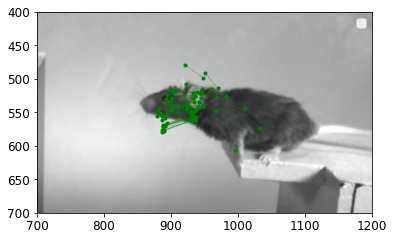

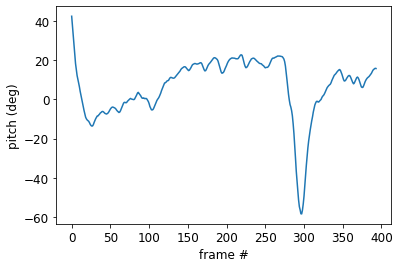

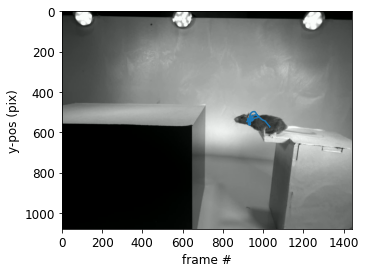

In [582]:
lh_thresh = 0.95

row = df_all.iloc[201]

ear_like = row['Side LEar likelihood'] < lh_thresh
eye_like = row['Side LEye likelihood'] < lh_thresh
rho_like = ear_like & eye_like
rho_like = rho_like[2:-2]

ear_x = row['Side LEar x'][2:-2]
ear_y = row['Side LEar y'][2:-2]
eye_x = row['Side LEye x'][2:-2]
eye_y = row['Side LEye y'][2:-2]


plt.figure()

vid_dir = r'T:\jumping_revisions'
side = 'Side'
frame_num = 200
vid_file = am.vidname_from_row(vid_dir,side,row)
print(vid_file)
frame,fps,frame_width,frame_height,ret = am.grab_vidframe(vid_file,frame_num)
plt.imshow(frame)
plt.plot([ear_x[::10],eye_x[::10]],[ear_y[::10],eye_y[::10]],'g.-',linewidth=0.25)
plt.axis([700,1200,700,400])
# plt.plot(ear_x,ear_y,'bo-',label='ear')
# plt.plot(eye_x,eye_y,'ro-',label='eye')
plt.legend()


# plt.figure()
# plt.hist(row['Side LEar likelihood'])

rho = np.degrees(np.arctan2(eye_y-ear_y,ear_x-eye_x))

rho[rho_like] = np.nan

plt.figure()
plt.plot(rho)
plt.ylabel('pitch (deg)')
plt.xlabel('frame #')
plt.figure()
plt.imshow(frame)
plt.plot(ear_x,ear_y)
plt.ylabel('y-pos (pix)')
plt.xlabel('frame #')

# Calculate pitch

In [565]:
lh_thresh = 0.95
start_fr = 0#-200
side_pitch = []
side_position = []

for index,row in df_all.iterrows():

    ear_like = row['Side LEar likelihood'] < lh_thresh
    eye_like = row['Side LEye likelihood'] < lh_thresh
    rho_like = ear_like & eye_like
    rho_like = rho_like[start_fr:-2]

    ear_x = row['Side LEar x'][start_fr:-2]
    ear_y = row['Side LEar y'][start_fr:-2]
    eye_x = row['Side LEye x'][start_fr:-2]
    eye_y = row['Side LEye y'][start_fr:-2]
    # get head angle
    rho = np.degrees(np.arctan2(eye_y-ear_y,ear_x-eye_x))
    rho[rho_like] = np.nan

    side_pitch.append(rho)
    side_position.append(eye_y)

df_all['Side_pitch'] = side_pitch
df_all['Side_pitch_mean'] = [np.nanmean(r) for r in side_pitch]
df_all['Side_pitch_std'] = [np.nanstd(r) for r in side_pitch]
df_all['Side_position_mean'] = [np.nanmean(r) for r in side_position]
df_all['Side_position_std'] = [np.nanstd(r) for r in side_position]

## Create a PDF to save out side plots

In [633]:
pdf_file = r'T:\jumping_revisions_analysis\side_analysis.pdf'
pp = PdfPages(pdf_file)

In [634]:
variable = 'Side_pitch_mean'

cond = 'controlopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,variable,'expt_group','laser_trial',0,40,plot_params,True,pp,suptitle='binocular opto last 2s')

cond = 'sutureopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,variable,'expt_group','laser_trial',0,40,plot_params,True,pp,suptitle='monocular opto last 2s')


condition = 'ocular'

df_cond = df_all[(df_all['condition']=='control')|(df_all['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance(df_cond,variable,condition,0,50,plot_params,True,pp,suptitle='')
am.plot_variable_vs_distance_manipulation(df_cond,variable,'success',condition,0,50,plot_params,True,pp,suptitle='failure (0) vs. success (1)')

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'1'}, xlabel='gap distance (cm)', ylabel='Side_pitch_mean'>)

In [635]:
variable = 'Side_position_mean'
lim1=525
lim2=575

cond = 'controlopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,variable,'expt_group','laser_trial',lim1,lim2,plot_params,True,pp,suptitle='binocular opto last 2s')

cond = 'sutureopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,variable,'expt_group','laser_trial',lim1,lim2,plot_params,True,pp,suptitle='monocular opto last 2s')


condition = 'ocular'

df_cond = df_all[(df_all['condition']=='control')|(df_all['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance(df_cond,variable,condition,lim1,lim2,plot_params,True,pp,suptitle='')
am.plot_variable_vs_distance_manipulation(df_cond,variable,'success',condition,lim1,lim2,plot_params,True,pp,suptitle='failure (0) vs. success (1)')

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'1'}, xlabel='gap distance (cm)', ylabel='Side_position_mean'>)

In [636]:
variable = 'Side_pitch_std'
cond = 'controlopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,variable,'expt_group','laser_trial',0,20,plot_params,True,pp,suptitle='binocular opto last 2s')

cond = 'sutureopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,variable,'expt_group','laser_trial',0,20,plot_params,True,pp,suptitle='monocular opto last 2s')


condition = 'ocular'

df_cond = df_all[(df_all['condition']=='control')|(df_all['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance(df_cond,variable,condition,0,20,plot_params,True,pp,suptitle='')
am.plot_variable_vs_distance_manipulation(df_cond,variable,'success',condition,0,20,plot_params,True,pp,suptitle='failure (0) vs. success (1)')

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'1'}, xlabel='gap distance (cm)', ylabel='Side_pitch_std'>)

In [637]:
dt = 0.01
start_fr = 2
rms_vel = []
for index,row in df_all.iterrows():
    x_trace = row['Side LEye x'][2:-2]
    y_trace = row['Side LEye y'][2:-2]
    x_trace = np.diff(x_trace[-200:])/row['Side_pixpercm']
    y_trace = np.diff(y_trace[-200:])/row['Side_pixpercm']

    vel = np.sqrt((x_trace)**2 + (y_trace)**2)/dt
    rms_vel.append(np.sqrt(np.mean(np.square(vel))))

df_all['rms_vel'] = rms_vel

variable = 'rms_vel'

condition = 'ocular'
df_cond = df_all[(df_all['condition']=='control')|(df_all['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance(df_cond,variable,condition,0,10,plot_params,True,pp,suptitle='')
am.plot_variable_vs_distance_manipulation(df_cond,variable,'success','ocular',0,10,plot_params,True,pp,suptitle='by success')

cond = 'controlopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,'rms_vel','expt_group','laser_trial',0,10,plot_params,True,pp,suptitle='binocular opto last 2s')

cond = 'sutureopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,'rms_vel','expt_group','laser_trial',0,10,plot_params,True,pp,suptitle='monocular opto last 2s')


(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'WT'}, xlabel='gap distance (cm)', ylabel='rms_vel'>)

### close the pdf

In [638]:
pp.close()

In [348]:
# make histograms of pitch
polar_bins = np.arange(-90,92,2)
bin_centers = polar_bins[:-1] + 15/2
pitch_hists = []
for i,item in enumerate(df_all['Side_pitch']):
    pitch_hist,bin_edges = np.histogram(item,bins=polar_bins)
    pitch_hists.append(pitch_hist)

len(pitch_hists)
df_all['pitch_hists'] = pitch_hists

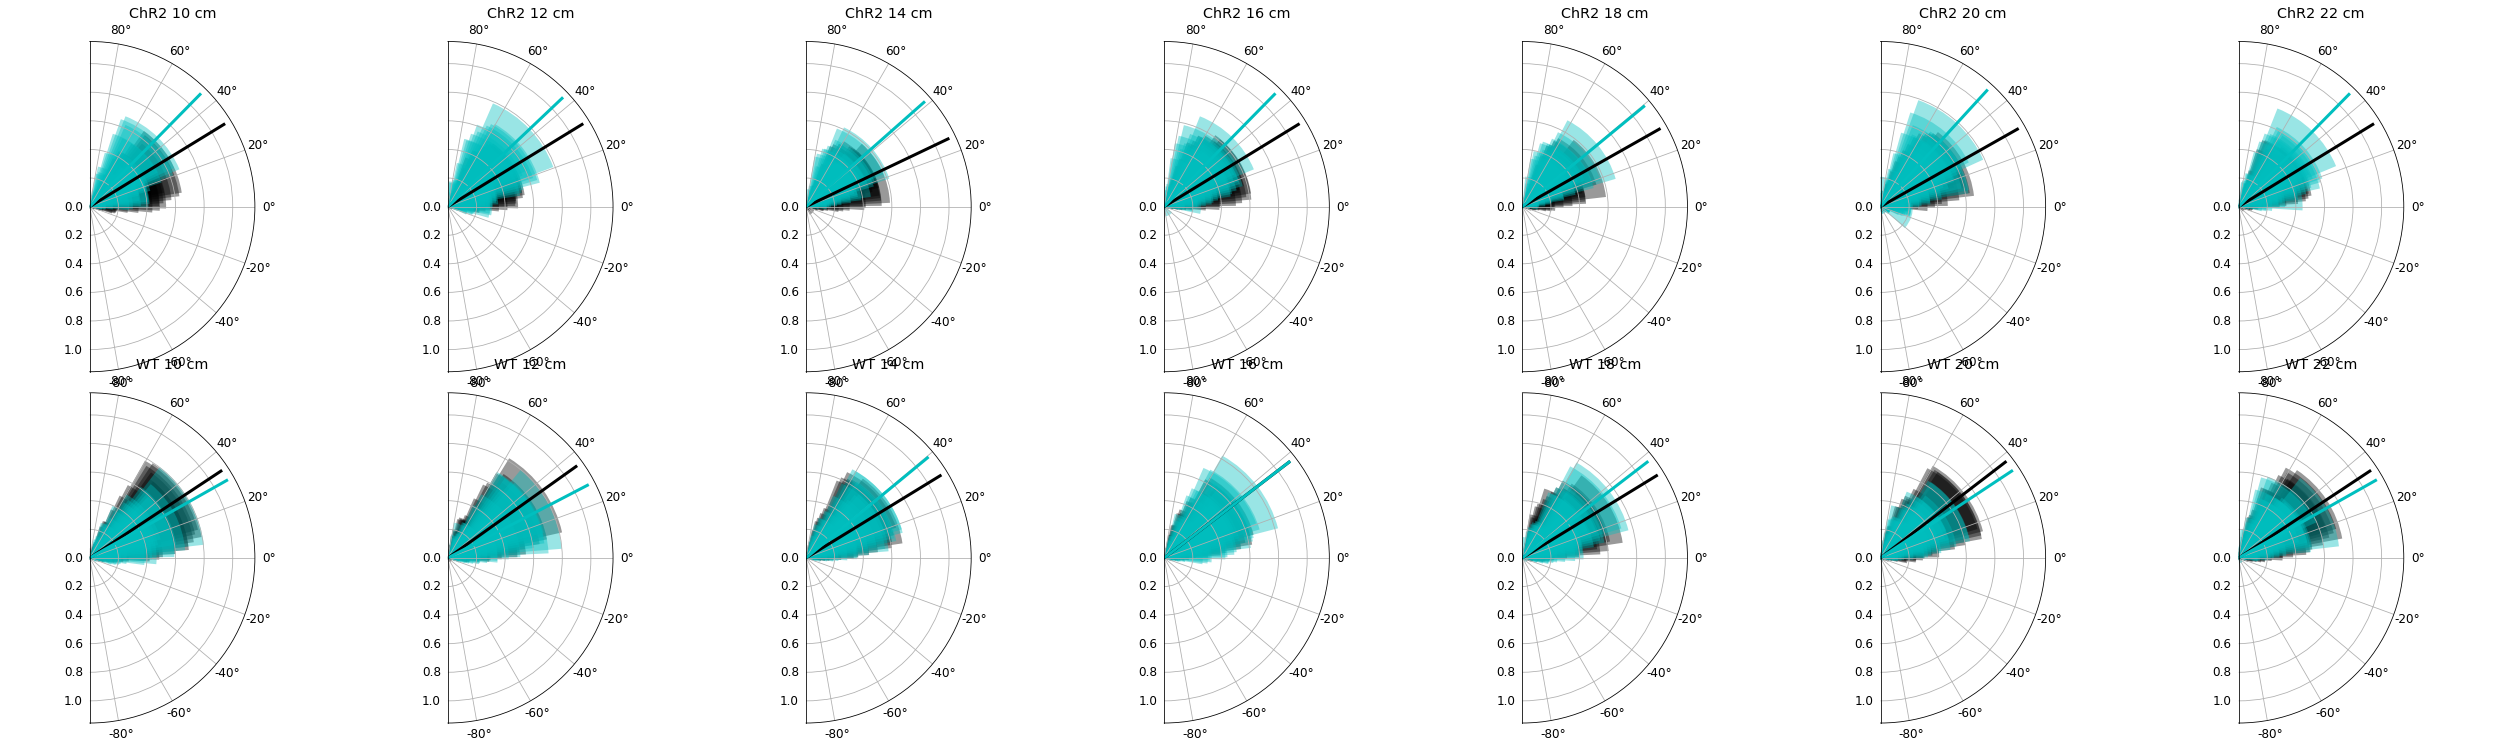

In [349]:
cond = 'controlopto'
df_cond = df_all[df_all['condition']==cond]
df_cond.reset_index(inplace=True,drop=True)

condition = 'expt_group'
manipulation = 'laser_trial'
dists = np.unique(df_cond['distance_DLC'])
anis = np.unique(df_cond['subject'])
conds = np.unique(df_cond[condition])
mans = np.unique(df_cond[manipulation])

fig, axs = plt.subplots(len(conds),len(dists),figsize=(5*len(dists),5*len(conds)),subplot_kw={'projection': 'polar'})
for c,cond in enumerate(conds):
    for d,dist in enumerate(dists):
        for m,man in enumerate(mans):
            
            pitch_hists = np.zeros((len(anis),len(bin_centers)))
            for a,ani in enumerate(anis):
                df_plot = df_cond[(df_cond[condition]==cond)&(df_cond['distance_DLC']==dist)&(df_cond[manipulation]==man)&(df_cond['subject']==ani)]
                if len(df_plot)==0:
                    pitch_hists[a,:] = np.array([np.nan] * len(bin_centers))
                else:
                    pitch_hists[a,:] = df_plot['pitch_hists'].mean()/np.max(df_plot['pitch_hists'].mean())
            
            ax = axs[c,d]
            mn_norm_pitch = np.nanmean(pitch_hists,axis=0)
            # mn_norm_pitch /= np.max(mn_norm_pitch)
            max_ind = np.radians(bin_centers[np.argmax(mn_norm_pitch)])

            ax.bar(np.radians(bin_centers),mn_norm_pitch,color=plot_params['laser_col'][m],alpha=0.4)
            ax.plot([max_ind, max_ind],[0, 1.1],'-',linewidth=3,color=plot_params['laser_col'][m])
        ax.set_rlabel_position(-22.5)
        ax.set_title('%s %d cm' % (cond,dist))
        ax.set_thetamin(-90)
        ax.set_thetamax(90)
fig.tight_layout()
            

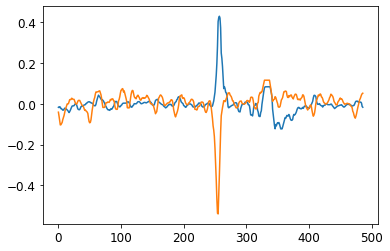

In [396]:
plt.plot(x_trace)
plt.plot(y_trace)

# Analyze RMS head velocity (side)

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'1'}, xlabel='gap distance (cm)', ylabel='rms_vel'>)

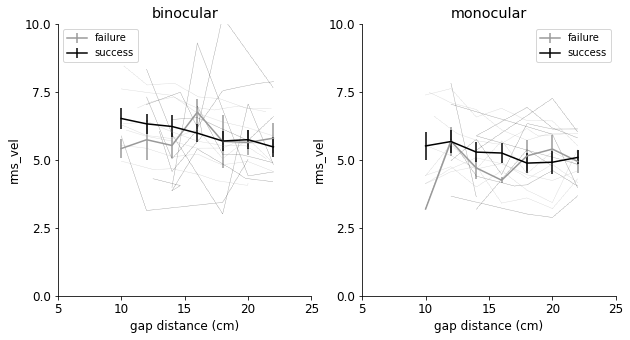

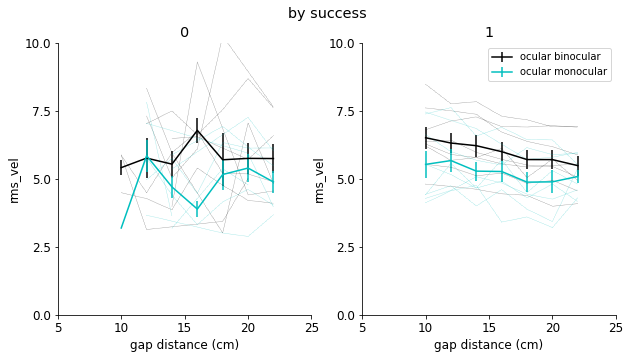

In [438]:
dt = 0.01
start_fr = 2
rms_vel = []
for index,row in df_all.iterrows():
    x_trace = row['Side LEye x'][2:-2]
    y_trace = row['Side LEye y'][2:-2]
    x_trace = np.diff(x_trace[-200:])/row['Side_pixpercm']
    y_trace = np.diff(y_trace[-200:])/row['Side_pixpercm']

    vel = np.sqrt((x_trace)**2 + (y_trace)**2)/dt
    rms_vel.append(np.sqrt(np.mean(np.square(vel))))

df_all['rms_vel'] = rms_vel

variable = 'rms_vel'

condition = 'ocular'
df_cond = df_all[(df_all['condition']=='control')|(df_all['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance(df_cond,variable,condition,0,10,plot_params,True,pp,suptitle='')
am.plot_variable_vs_distance_manipulation(df_cond,variable,'success','ocular',0,10,plot_params,True,pp,suptitle='by success')

cond = 'controlopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,'rms_vel','expt_group','laser_trial',0,10,plot_params,True,pp,suptitle='binocular opto last 2s')

cond = 'sutureopto'
df_cond = df_all[(df_all['condition']==cond)&(df_all['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,'rms_vel','expt_group','laser_trial',0,10,plot_params,True,pp,suptitle='monocular opto last 2s')


# Incoroporate side cam DLC points into dataframe and save out

In [13]:
# load metadata
data = pd.read_hdf(metadata_file,key='df')

# add DLC data to dataframe for top-down cam only
lh_thresh = 0.95
df_jump = am.load_dlc_h5_jump_data(data,['Top'],dlc_path,lh_thresh)

trying 012922_PVCHA7LN_control_0
trying 012922_PVCHA7LN_control_1
trying 012922_PVCHA7LN_control_2
trying 012922_PVCHA7LN_control_3
trying 012922_PVCHA7LN_control_4
trying 012922_PVCHA7LN_control_5
trying 012922_PVCHA7LN_control_6
trying 012922_PVCHA7LN_control_7
trying 012922_PVCHA7LN_control_8
trying 012922_PVCHA7LN_control_9
trying 012922_PVCHA7LN_control_10
trying 012922_PVCHA7LN_control_11
trying 012922_PVCHA7LN_control_12
trying 012922_PVCHA7LN_control_13
trying 012922_PVCHA7LN_control_14
trying 012922_PVCHA7LN_control_15
trying 012922_PVCHA7LN_control_16
trying 012922_PVCHA7LN_control_17
trying 012922_PVCHA7LN_control_18
trying 012922_PVCHA7LN_control_19
trying 012922_PVCHA7LN_control_20
trying 012922_PVCHA7LN_control_21
trying 012922_PVCHA7LN_control_22
trying 012922_PVCHA7LN_control_23
trying 012922_PVCHA7LN_control_24
trying 012922_PVCHA7LN_control_25
trying 012922_PVCHA7LN_control_26
trying 012922_PVCHA7LN_control_27
trying 012922_PVCHA7LN_control_28
trying 012922_PVCHA7LN_c

In [14]:
# save the top data
data_file = r'T:\jumping_revisions_analysis\df_jumpDLCpts.h5'

df_jump.to_hdf(data_file,key='df',mode='w')

# Analyze landing position

In [690]:
# load the data
data_file = r'T:\jumping_revisions_analysis\df_jumpDLCpts.h5'

df_jump = pd.read_hdf(data_file,key='df')
df_jump.shape

(8814, 53)

In [691]:
# infer platform and distance based on DLC points in case there are errors in the experiment metadata

l_thresh = 0.99
plt_keys = ['LandFL','LandFR','TakeFL','TakeFR']
vid_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\clipped_vids'
sides = ['Top']
plats = (np.array([15,20,25])).astype(int)
D,P = ([] for i in range(2))
# pdf_file = r'C:\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\all_trial_plots.pdf'
# pp = PdfPages(pdf_file)

for index, row in df_jump.iterrows():
#     fig, axs = plt.subplots(1,len(sides),figsize=(3*len(sides),3))
    for s,side in enumerate(sides):
#         ax = axs[s]
#         frame_nums = [0,row[side + '_End']-row[side + '_Start']]
#         file = am.vidname_from_row(vid_dir,side,row)
#         frame = combine_images(file,frame_nums)
#         ax.imshow(frame)
        for key in plt_keys:
            like = row[side + ' ' + key + ' likelihood']>l_thresh
            xtr = row[side + ' ' + key + ' x'][like]
            ytr = row[side + ' ' + key + ' y'][like]
#             ax.plot(xtr,ytr,'.',markersize=1,label=key)
            if side=='Top':
                if key=='LandFR':
                    LandFR_x = np.nanmedian(xtr)
                    LandFR_y = np.nanmedian(ytr)
                elif key=='LandFL':
                    LandFL_x = np.nanmedian(xtr)
                    LandFL_y = np.nanmedian(ytr)
                elif key=='TakeFR':
                    TakeFR_x = np.nanmedian(xtr)
                elif key=='TakeFL':
                    TakeFL_x = np.nanmedian(xtr)
#         ax.axis('off')
    try:
        est_dist = int((np.nanmean([TakeFR_x,TakeFL_x])-np.nanmean([LandFR_x,LandFL_x]))/row['Top_pixpercm'])
    except:
        est_dist = 0
    D.append(est_dist)
    try:
        est_plat = int((LandFL_y-LandFR_y)/row['Top_pixpercm'])
    except:
        est_plat = 0
    P.append(est_plat)
D = np.array(D)
P = np.array(P)
#     ax.legend(fontsize=4,loc=1)
#     ax.text(720/4,540/6,,
#            fontsize=10)
#     fig.suptitle('%s %s trial %s plat %scm (est %scm) gapdist %scm (est %scm) jumpdist %scm outcome %s' % \
#             (row['expdate'],row['subject'],row['trial'],plats[row['platform']-1],est_plat,row['distance'],est_dist,
#              int(row['jumpdist']),row['success']),fontsize=8)
#     fig.tight_layout()
#     pp.savefig(fig)
#     plt.close(fig)
# pp.close()

d = df_jump['distance'].to_numpy()
p = df_jump['platform'].to_numpy()

Dinds = np.where(np.abs(D-d)>=2)[0]
Pinds = np.where(np.abs(P-p*10)>=5)[0]
inds = set(Dinds) ^ set(Pinds)
print(len(Dinds),len(Pinds),len(inds))

df_jump_temp = df_jump.copy()
df_jump_temp['distance_DLC'] = D
df_jump_temp['platform_DLC'] = P

df_jump_temp['platform_DLC'] = df_jump_temp['platform_DLC'].replace([16,21,22,26],[15,20,25,25])
df_jump_temp['platform_DLC'] = df_jump_temp['platform_DLC'].replace([15,20,25],[1,2,3])

df_jump_temp['distance_DLC'] = df_jump_temp['distance_DLC'].replace([4,11,13,15,17,19,21,23,24],[22,10,12,14,16,18,20,22,22])

# ### remove these (bad trials)
to_remove = np.where((df_jump_temp['platform_DLC']==0).tolist()|(df_jump_temp['distance_DLC']==0)|(df_jump_temp['distance_DLC']==5))[0].tolist()
# to_remove = np.where((df_jump_temp['platform_DLC']==0)|(df_jump_temp['platform_DLC']==22)|(df_jump_temp['distance_DLC']==0)|(df_jump_temp['distance_DLC']==5)|(df_jump_temp['distance_DLC']==4))[0]
df_jump_temp = df_jump_temp.drop(to_remove)
df_jump_temp.reset_index(inplace=True,drop=True)

### get jump accuracy
df_jump_temp = am.get_jump_accuracy(df_jump_temp)

print(np.unique(df_jump_temp['platform_DLC']),np.unique(df_jump_temp['distance_DLC']))
print(len(df_jump),len(df_jump_temp))

303 3063 2910
[1 2 3] [10 12 14 16 18 20 22]
8814 8797


In [692]:
# save out corrected dataframe
data_file = r'T:\jumping_revisions_analysis\df_jumpDLCpoints_corrected.h5'

df_jump_temp.to_hdf(data_file,key='df',mode='w')

In [358]:
# Dinds = np.where(df_jump_temp['distance']!=df_jump_temp['distance_DLC'])[0]
# Pinds = np.where(df_jump_temp['platform']!=df_jump_temp['platform_DLC'])[0]
# inds = set(Dinds) ^ set(Pinds)
# print(len(Dinds),len(Pinds),len(inds))

# df_jump_temp = df_jump_temp.drop(Dinds)
# df_jump_temp.shape

In [ ]:
# jdiff_idx = (df_jump_temp['jumpdist']-df_jump_temp['distance_DLC'])<-4
# suc_idx = df_jump_temp['success']==1
# prob_idx = np.where(jdiff_idx&suc_idx)[0]
# len(prob_idx)

# df_jump_temp = df_jump_temp.drop(prob_idx)
# df_jump_temp.reset_index(inplace=True,drop=True)
# df_jump_temp.shape

(8567, 37)

# create a pdf to check start and end positions for every trial in the dataset

In [33]:
pdf_file = r'T:\jumping_revisions_analysis\trial_verification.pdf'
pp = PdfPages(pdf_file)

vid_dir = r'T:\jumping_revisions'
side = 'Side'

for index,row in df_jump_temp.iterrows():

    if np.mod(index,25)==0:
        print('currently on row %d' % index)

    fig, axs = plt.subplots(2,4,figsize = (8,4))
    ju = int(row['Side_Jump'])
    starts = [ju-2,ju-1,ju,ju+1]
    en = int(row['Top_End'])
    ends = [en-3,en-2,en-1,en]

    for i,(start,end) in enumerate(zip(starts,ends)):
        vid_file = am.vidname_from_row(vid_dir,'Side',row)
        frame,fps,frame_width,frame_height,ret = am.grab_vidframe(vid_file,start)
        if ret:
            axs[0,i].imshow(frame[400:700,750:1050,:])
        vid_file = am.vidname_from_row(vid_dir,'Top',row)
        frame,fps,frame_width,frame_height,ret = am.grab_vidframe(vid_file,end)
        if ret:
            axs[1,i].imshow(frame)

    axs = axs.ravel()
    for ax in axs:
        ax.axis('off')

    fig.suptitle('%s %s trial %s plat=%s dist=%s suc=%s laser=%s' % (row['expdate'],row['subject'],str(row['trial']),str(row['platform']),str(row['distance']),str(row['success']),str(row['laser_trial'])))

    pp.savefig(fig)
    plt.close(fig)

pp.close()


currently on row 0
currently on row 25
currently on row 50
currently on row 75
currently on row 100
currently on row 125
currently on row 150
currently on row 175
currently on row 200
currently on row 225
currently on row 250
currently on row 275
currently on row 300
currently on row 325
currently on row 350
currently on row 375
currently on row 400
currently on row 425
currently on row 450
currently on row 475
currently on row 500
currently on row 525
currently on row 550
currently on row 575
currently on row 600
currently on row 625
currently on row 650
currently on row 675
currently on row 700
currently on row 725
currently on row 750
currently on row 775
currently on row 800
currently on row 825
currently on row 850
currently on row 875
currently on row 900
currently on row 925
currently on row 950
currently on row 975
currently on row 1000
currently on row 1025
currently on row 1050
currently on row 1075
currently on row 1100
currently on row 1125
currently on row 1150
currently o

# Analyze head angle (top)

In [664]:
# load the data
data_file = r'T:\jumping_revisions_analysis\df_decision_alldata_Top.h5'

df_jump_temp = pd.read_hdf(data_file,key='df')
df_jump_temp.shape

(8797, 56)

No handles with labels found to put in legend.


Text(0.5, 0, 'frame #')

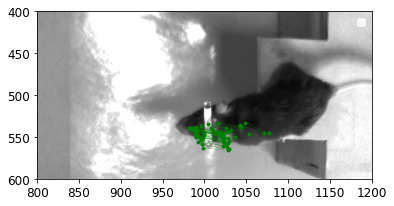

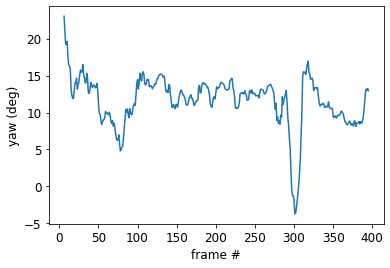

In [232]:
lh_thresh = 0.95

row = df_jump_temp.iloc[201]

jump_fr = int(row['Top_Jump']-row['Top_Start'])
ear_like = row['Top LEar likelihood'] < lh_thresh
eye_like = row['Top LEye likelihood'] < lh_thresh
rho_like = ear_like & eye_like
rho_like = rho_like[2:jump_fr]

ear_x = row['Top LEar x'][2:jump_fr]
ear_y = row['Top LEar y'][2:jump_fr]
eye_x = row['Top LEye x'][2:jump_fr]
eye_y = row['Top LEye y'][2:jump_fr]


plt.figure()

vid_dir = r'T:\jumping_revisions'
side = 'Top'
frame_num = 200
vid_file = am.vidname_from_row(vid_dir,side,row)
frame,fps,frame_width,frame_height,ret = am.grab_vidframe(vid_file,frame_num)
plt.imshow(frame)

plt.plot([ear_x[::10],eye_x[::10]],[ear_y[::10],eye_y[::10]],'g.-',linewidth=0.25)
# plt.plot(ear_x,ear_y,'bo-',label='ear')
# plt.plot(eye_x,eye_y,'ro-',label='eye')
plt.axis([800,1200,600,400])
plt.legend()


# plt.figure()
# plt.hist(row['Top LEar likelihood'])

rho = np.degrees(np.arctan2(ear_y-eye_y,ear_x-eye_x))

rho[rho_like] = np.nan

plt.figure()
plt.plot(rho)
plt.ylabel('yaw (deg)')
plt.xlabel('frame #')

## Calculate yaw and std of yaw from top-down camera

In [665]:
lh_thresh = 0.95
start_fr = -200
top_yaw = []

for index,row in df_jump_temp.iterrows():

    jump_fr = int(row['Top_Jump']-row['Top_Start'])

    ear_like = row['Top LEar likelihood'] < lh_thresh
    eye_like = row['Top LEye likelihood'] < lh_thresh
    rho_like = ear_like & eye_like
    rho_like = rho_like[start_fr:jump_fr]

    ear_x = row['Top LEar x'][start_fr:jump_fr]
    ear_y = row['Top LEar y'][start_fr:jump_fr]
    eye_x = row['Top LEye x'][start_fr:jump_fr]
    eye_y = row['Top LEye y'][start_fr:jump_fr]
    # get head angle
    rho = np.degrees(np.arctan2(ear_y-eye_y,ear_x-eye_x))
    rho[rho_like] = np.nan

    top_yaw.append(rho)

df_jump_temp['Top_yaw'] = top_yaw
df_jump_temp['Top_yaw_std'] = [np.nanstd(r) for r in top_yaw]

## Start a pdf to store top-down plots

In [685]:
pdf_file = r'T:\jumping_revisions_analysis\top_down_decision_analysis.pdf'
pp = PdfPages(pdf_file)

### plot yaw std

In [686]:
cond = 'controlopto'
df_cond = df_jump_temp[(df_jump_temp['condition']==cond)&(df_jump_temp['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,'Top_yaw_std','expt_group','laser_trial',0,20,plot_params,True,pp,suptitle='binocular opto last 2s')

cond = 'sutureopto'
df_cond = df_jump_temp[(df_jump_temp['condition']==cond)&(df_jump_temp['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,'Top_yaw_std','expt_group','laser_trial',0,20,plot_params,True,pp,suptitle='monocular opto last 2s')

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'WT'}, xlabel='gap distance (cm)', ylabel='Top_yaw_std'>)

In [687]:
variable = 'Top_yaw_std'
condition = 'ocular'

df_cond = df_jump_temp[(df_jump_temp['condition']=='control')|(df_jump_temp['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance(df_cond,variable,condition,0,50,plot_params,True,pp,suptitle='')
am.plot_variable_vs_distance_manipulation(df_cond,variable,'success',condition,0,20,plot_params,True,pp,suptitle='failure (0) vs. success (1)')

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'1'}, xlabel='gap distance (cm)', ylabel='Top_yaw_std'>)

### plot rms velocity top

In [688]:
dt = 0.01
start_fr = 2
rms_vel = []
for index,row in df_jump_temp.iterrows():
    x_trace = row['Top LEye x'][2:-2]
    y_trace = row['Top LEye y'][2:-2]
    x_trace = np.diff(x_trace[-200:])/row['Top_pixpercm']
    y_trace = np.diff(y_trace[-200:])/row['Top_pixpercm']

    vel = np.sqrt((x_trace)**2 + (y_trace)**2)/dt
    rms_vel.append(np.sqrt(np.mean(np.square(vel))))

df_jump_temp['rms_vel'] = rms_vel

variable = 'rms_vel'

condition = 'ocular'
df_cond = df_jump_temp[(df_jump_temp['condition']=='control')|(df_jump_temp['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance(df_cond,variable,condition,0,10,plot_params,True,pp,suptitle='')
am.plot_variable_vs_distance_manipulation(df_cond,variable,'success','ocular',0,10,plot_params,True,pp,suptitle='by success')

cond = 'controlopto'
df_cond = df_jump_temp[(df_jump_temp['condition']==cond)&(df_jump_temp['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,'rms_vel','expt_group','laser_trial',0,10,plot_params,True,pp,suptitle='binocular opto last 2s')

cond = 'sutureopto'
df_cond = df_jump_temp[(df_jump_temp['condition']==cond)&(df_jump_temp['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance_manipulation(df_cond,'rms_vel','expt_group','laser_trial',0,10,plot_params,True,pp,suptitle='monocular opto last 2s')


(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'WT'}, xlabel='gap distance (cm)', ylabel='rms_vel'>)

In [689]:
pp.close()

# Making landing position PDF

In [693]:
data_file = r'T:\jumping_revisions_analysis\df_jumpDLCpoints_corrected.h5'
df_jump_temp = pd.read_hdf(data_file,key='df')

In [694]:
pdf_file = r'T:\jumping_revisions_analysis\top_down_landing_analysis.pdf'
pp = PdfPages(pdf_file)

### Plot changes in landing position

In [695]:
cond = 'controlopto'
df_cond = df_jump_temp[(df_jump_temp['condition']==cond)&(df_jump_temp['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)

dists = np.unique(df_cond['distance_DLC'])
anis = np.unique(df_cond['subject'])
laser_label = np.unique(df_cond['laser_trial'])

mn_land_xy_diff = np.zeros((len(dists),2,int(len(anis)/2)))
mn_land_x_diff = np.zeros((len(dists),2,int(len(anis)/2)))
mn_land_y_diff = np.zeros((len(dists),2,int(len(anis)/2)))
std_land_x = np.zeros((len(dists),2,2,int(len(anis)/2))) #dists,laser,group,animal
std_land_y = np.zeros((len(dists),2,2,int(len(anis)/2)))

wt_count = -1
ch_count = -1

for a,ani in enumerate(anis):
    df_ani = df_cond[(df_cond['subject']==ani)&(df_cond['success']==1)]
    df_ani.reset_index(inplace=True,drop=True)

    if df_ani['expt_group'].iloc[0]=='WT':
        grp='WT'
        wt_count += 1
    else:
        grp='ChR2'
        ch_count += 1

    for d,dist in enumerate(dists):
        mn_land = np.zeros(4) #x1,x2,y1,y2
        std_land = np.zeros(4) #x1,x2,y1,y2
        for l,laser in enumerate(laser_label):
            temp_df = df_ani[(df_ani['distance_DLC']==dist)&(df_ani['laser_trial']==laser)]
            temp_df.reset_index(inplace=True,drop=True)

            #get landing positions
            xs = [i[-1] for i in temp_df['Top LEar x']]
            ys = [i[-1] for i in temp_df['Top LEar y']]
    
            mn_land[l] = np.nanmean(xs)/df_ani['Top_pixpercm'].iloc[0]
            mn_land[l+2] = np.nanmean(ys)/df_ani['Top_pixpercm'].iloc[0]
            std_land[l] = np.nanstd(xs)/df_ani['Top_pixpercm'].iloc[0]
            std_land[l+2] = np.nanstd(ys)/df_ani['Top_pixpercm'].iloc[0]
        if grp=='WT':
            mn_land_xy_diff[d,0,wt_count] = np.sqrt((mn_land[1]-mn_land[0])**2 + (mn_land[3]-mn_land[2])**2)
            mn_land_x_diff[d,0,wt_count] = np.abs(mn_land[1]-mn_land[0])
            mn_land_y_diff[d,0,wt_count] = np.abs(mn_land[3]-mn_land[2])
            std_land_x[d,0,0,wt_count] = std_land[0]
            std_land_x[d,1,0,wt_count] = std_land[1]
            std_land_y[d,0,0,wt_count] = std_land[2]
            std_land_y[d,1,0,wt_count] = std_land[3]
        else:
            mn_land_xy_diff[d,1,ch_count] = np.sqrt((mn_land[1]-mn_land[0])**2 + (mn_land[3]-mn_land[2])**2)
            mn_land_x_diff[d,1,ch_count] = np.abs(mn_land[1]-mn_land[0])
            mn_land_y_diff[d,1,ch_count] = np.abs(mn_land[3]-mn_land[2])
            std_land_x[d,0,1,ch_count] = std_land[0]
            std_land_x[d,1,1,ch_count] = std_land[1]
            std_land_y[d,0,1,ch_count] = std_land[2]
            std_land_y[d,1,1,ch_count] = std_land[3]


fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(x=dists,y=np.nanmean(mn_land_xy_diff[:,0,:],axis=1),yerr=np.nanstd(mn_land_xy_diff[:,0,:],axis=1)/np.sqrt(4),color='k',label='WT')
ax.errorbar(x=dists,y=np.nanmean(mn_land_xy_diff[:,1,:],axis=1),yerr=np.nanstd(mn_land_xy_diff[:,1,:],axis=1)/np.sqrt(4),color='c',label='ChR2')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('laser-induced change in landing position (cm)',fontsize=12)
ax.legend()
fig.suptitle(cond)
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(x=dists,y=np.nanmean(mn_land_x_diff[:,0,:],axis=1),yerr=np.nanstd(mn_land_x_diff[:,0,:],axis=1)/np.sqrt(4),color='k',label='WT')
ax.errorbar(x=dists,y=np.nanmean(mn_land_x_diff[:,1,:],axis=1),yerr=np.nanstd(mn_land_x_diff[:,1,:],axis=1)/np.sqrt(4),color='c',label='ChR2')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('distance change',fontsize=12)
ax.legend()
fig.suptitle(cond)
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(x=dists,y=np.nanmean(mn_land_y_diff[:,0,:],axis=1),yerr=np.nanstd(mn_land_y_diff[:,0,:],axis=1)/np.sqrt(4),color='k',label='WT')
ax.errorbar(x=dists,y=np.nanmean(mn_land_y_diff[:,1,:],axis=1),yerr=np.nanstd(mn_land_y_diff[:,1,:],axis=1)/np.sqrt(4),color='c',label='ChR2')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('lateral change',fontsize=12)
ax.legend()
fig.suptitle(cond)
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs = axs.ravel()
ax = axs[0]
ax.errorbar(x=dists,y=np.nanmean(std_land_x[:,0,0,:],axis=1),yerr=np.nanstd(std_land_x[:,0,0,:],axis=1)/np.sqrt(4),color='k',label='laser off')
ax.errorbar(x=dists,y=np.nanmean(std_land_x[:,1,0,:],axis=1),yerr=np.nanstd(std_land_x[:,0,0,:],axis=1)/np.sqrt(4),color='c',label='laser on')
ax.set_title('WT')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('distance std',fontsize=12)
ax = axs[1]
ax.errorbar(x=dists,y=np.nanmean(std_land_x[:,0,1,:],axis=1),yerr=np.nanstd(std_land_x[:,0,1,:],axis=1)/np.sqrt(4),color='k',label='laser off')
ax.errorbar(x=dists,y=np.nanmean(std_land_x[:,1,1,:],axis=1),yerr=np.nanstd(std_land_x[:,0,1,:],axis=1)/np.sqrt(4),color='c',label='laser on')
ax.set_title('ChR2')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('distance std',fontsize=12)
ax.legend()
fig.suptitle(cond)
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs = axs.ravel()
ax = axs[0]
ax.errorbar(x=dists,y=np.nanmean(std_land_y[:,0,0,:],axis=1),yerr=np.nanstd(std_land_y[:,0,0,:],axis=1)/np.sqrt(4),color='k',label='laser off')
ax.errorbar(x=dists,y=np.nanmean(std_land_y[:,1,0,:],axis=1),yerr=np.nanstd(std_land_y[:,1,0,:],axis=1)/np.sqrt(4),color='c',label='laser on')
ax.set_title('WT')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('lateral std',fontsize=12)
ax = axs[1]
ax.errorbar(x=dists,y=np.nanmean(std_land_y[:,0,1,:],axis=1),yerr=np.nanstd(std_land_y[:,0,1,:],axis=1)/np.sqrt(4),color='k',label='laser off')
ax.errorbar(x=dists,y=np.nanmean(std_land_y[:,1,1,:],axis=1),yerr=np.nanstd(std_land_y[:,1,1,:],axis=1)/np.sqrt(4),color='c',label='laser on')
ax.set_title('ChR2')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('lateral std',fontsize=12)
ax.legend()
fig.suptitle(cond)
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

In [696]:
cond = 'sutureopto'
df_cond = df_jump_temp[(df_jump_temp['condition']==cond)&(df_jump_temp['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)

dists = np.unique(df_cond['distance_DLC'])
anis = np.unique(df_cond['subject'])
laser_label = np.unique(df_cond['laser_trial'])

mn_land_xy_diff = np.zeros((len(dists),2,int(len(anis)/2)))
mn_land_x_diff = np.zeros((len(dists),2,int(len(anis)/2)))
mn_land_y_diff = np.zeros((len(dists),2,int(len(anis)/2)))
std_land_x = np.zeros((len(dists),2,2,int(len(anis)/2))) #dists,laser,group,animal
std_land_y = np.zeros((len(dists),2,2,int(len(anis)/2)))

wt_count = -1
ch_count = -1

for a,ani in enumerate(anis):
    df_ani = df_cond[(df_cond['subject']==ani)&(df_cond['success']==1)]
    df_ani.reset_index(inplace=True,drop=True)

    if df_ani['expt_group'].iloc[0]=='WT':
        grp='WT'
        wt_count += 1
    else:
        grp='ChR2'
        ch_count += 1

    for d,dist in enumerate(dists):
        mn_land = np.zeros(4) #x1,x2,y1,y2
        std_land = np.zeros(4) #x1,x2,y1,y2
        for l,laser in enumerate(laser_label):
            temp_df = df_ani[(df_ani['distance_DLC']==dist)&(df_ani['laser_trial']==laser)]
            temp_df.reset_index(inplace=True,drop=True)

            #get landing positions
            xs = [i[-1] for i in temp_df['Top LEar x']]
            ys = [i[-1] for i in temp_df['Top LEar y']]
    
            mn_land[l] = np.nanmean(xs)/df_ani['Top_pixpercm'].iloc[0]
            mn_land[l+2] = np.nanmean(ys)/df_ani['Top_pixpercm'].iloc[0]
            std_land[l] = np.nanstd(xs)/df_ani['Top_pixpercm'].iloc[0]
            std_land[l+2] = np.nanstd(ys)/df_ani['Top_pixpercm'].iloc[0]
        if grp=='WT':
            mn_land_xy_diff[d,0,wt_count] = np.sqrt((mn_land[1]-mn_land[0])**2 + (mn_land[3]-mn_land[2])**2)
            mn_land_x_diff[d,0,wt_count] = np.sqrt((mn_land[1]-mn_land[0])**2)
            mn_land_y_diff[d,0,wt_count] = np.sqrt((mn_land[3]-mn_land[2])**2)
            std_land_x[d,0,0,wt_count] = std_land[0]
            std_land_x[d,1,0,wt_count] = std_land[1]
            std_land_y[d,0,0,wt_count] = std_land[2]
            std_land_y[d,1,0,wt_count] = std_land[3]
        else:
            mn_land_xy_diff[d,1,ch_count] = np.sqrt((mn_land[1]-mn_land[0])**2 + (mn_land[3]-mn_land[2])**2)
            mn_land_x_diff[d,1,ch_count] = np.sqrt((mn_land[1]-mn_land[0])**2)
            mn_land_y_diff[d,1,ch_count] = np.sqrt((mn_land[3]-mn_land[2])**2)
            std_land_x[d,0,1,ch_count] = std_land[0]
            std_land_x[d,1,1,ch_count] = std_land[1]
            std_land_y[d,0,1,ch_count] = std_land[2]
            std_land_y[d,1,1,ch_count] = std_land[3]


fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(x=dists,y=np.nanmean(mn_land_xy_diff[:,0,:],axis=1),yerr=np.nanstd(mn_land_xy_diff[:,0,:],axis=1)/np.sqrt(4),color='k',label='WT')
ax.errorbar(x=dists,y=np.nanmean(mn_land_xy_diff[:,1,:],axis=1),yerr=np.nanstd(mn_land_xy_diff[:,1,:],axis=1)/np.sqrt(4),color='c',label='ChR2')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('laser-induced change in landing position (cm)',fontsize=12)
ax.legend()
fig.suptitle(cond)
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(x=dists,y=np.nanmean(mn_land_x_diff[:,0,:],axis=1),yerr=np.nanstd(mn_land_x_diff[:,0,:],axis=1)/np.sqrt(4),color='k',label='WT')
ax.errorbar(x=dists,y=np.nanmean(mn_land_x_diff[:,1,:],axis=1),yerr=np.nanstd(mn_land_x_diff[:,1,:],axis=1)/np.sqrt(4),color='c',label='ChR2')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('distance change',fontsize=12)
ax.legend()
fig.suptitle(cond)
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(x=dists,y=np.nanmean(mn_land_y_diff[:,0,:],axis=1),yerr=np.nanstd(mn_land_y_diff[:,0,:],axis=1)/np.sqrt(4),color='k',label='WT')
ax.errorbar(x=dists,y=np.nanmean(mn_land_y_diff[:,1,:],axis=1),yerr=np.nanstd(mn_land_y_diff[:,1,:],axis=1)/np.sqrt(4),color='c',label='ChR2')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('lateral change',fontsize=12)
ax.legend()
fig.suptitle(cond)
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs = axs.ravel()
ax = axs[0]
ax.errorbar(x=dists,y=np.nanmean(std_land_x[:,0,0,:],axis=1),yerr=np.nanstd(std_land_x[:,0,0,:],axis=1)/np.sqrt(4),color='k',label='laser off')
ax.errorbar(x=dists,y=np.nanmean(std_land_x[:,1,0,:],axis=1),yerr=np.nanstd(std_land_x[:,0,0,:],axis=1)/np.sqrt(4),color='c',label='laser on')
ax.set_title('WT')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('distance std',fontsize=12)
ax = axs[1]
ax.errorbar(x=dists,y=np.nanmean(std_land_x[:,0,1,:],axis=1),yerr=np.nanstd(std_land_x[:,0,1,:],axis=1)/np.sqrt(4),color='k',label='laser off')
ax.errorbar(x=dists,y=np.nanmean(std_land_x[:,1,1,:],axis=1),yerr=np.nanstd(std_land_x[:,0,1,:],axis=1)/np.sqrt(4),color='c',label='laser on')
ax.set_title('ChR2')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('distance std',fontsize=12)
ax.legend()
fig.suptitle(cond)
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs = axs.ravel()
ax = axs[0]
ax.errorbar(x=dists,y=np.nanmean(std_land_y[:,0,0,:],axis=1),yerr=np.nanstd(std_land_y[:,0,0,:],axis=1)/np.sqrt(4),color='k',label='laser off')
ax.errorbar(x=dists,y=np.nanmean(std_land_y[:,1,0,:],axis=1),yerr=np.nanstd(std_land_y[:,1,0,:],axis=1)/np.sqrt(4),color='c',label='laser on')
ax.set_title('WT')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('lateral std',fontsize=12)
ax = axs[1]
ax.errorbar(x=dists,y=np.nanmean(std_land_y[:,0,1,:],axis=1),yerr=np.nanstd(std_land_y[:,0,1,:],axis=1)/np.sqrt(4),color='k',label='laser off')
ax.errorbar(x=dists,y=np.nanmean(std_land_y[:,1,1,:],axis=1),yerr=np.nanstd(std_land_y[:,1,1,:],axis=1)/np.sqrt(4),color='c',label='laser on')
ax.set_title('ChR2')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('lateral std',fontsize=12)
ax.legend()
fig.suptitle(cond)
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

In [697]:
df_cond = df_jump_temp[(df_jump_temp['condition']=='control')|(df_jump_temp['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)

dists = np.unique(df_cond['distance_DLC'])
anis = np.unique(df_cond['subject'])
ocular = np.unique(df_cond['ocular'])

mn_land_diff = np.zeros((len(dists),int(len(anis))))

for a,ani in enumerate(anis):
    df_ani = df_cond[(df_cond['subject']==ani)&(df_cond['success']==1)]
    df_ani.reset_index(inplace=True,drop=True)

    for d,dist in enumerate(dists):
        mn_land = np.zeros(4) #x1,x2,y1,y2
        for o,oc in enumerate(ocular):
            temp_df = df_ani[(df_ani['distance_DLC']==dist)&(df_ani['ocular']==oc)]
            temp_df.reset_index(inplace=True,drop=True)

            #get landing positions
            xs = [i[-1] for i in temp_df['Top LEar x']]
            ys = [i[-1] for i in temp_df['Top LEar y']]
    
            mn_land[o] = np.nanmean(xs)/df_ani['Top_pixpercm'].iloc[0]
            mn_land[o+2] = np.nanmean(ys)/df_ani['Top_pixpercm'].iloc[0]
        mn_land_diff[d,a] = np.sqrt((mn_land[1]-mn_land[0])**2 + (mn_land[3]-mn_land[2])**2)


fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(x=dists,y=np.nanmean(mn_land_diff,axis=1),yerr=np.nanstd(mn_land_diff,axis=1)/np.sqrt(4),color='k')
ax.set_xlim(5,25)
ax.set_ylim(0,5)
ax.set_xlabel('gap distance')
ax.set_ylabel('ocular-induced change in landing position (cm)',fontsize=12)
ax.legend()
plt.suptitle('binocular vs. monocular difference')
fig.tight_layout()
pp.savefig(fig)
plt.close(fig)

No handles with labels found to put in legend.


In [698]:
pp.close()

# Old analysis

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'monocular'}, xlabel='gap distance (cm)', ylabel='land_y'>)

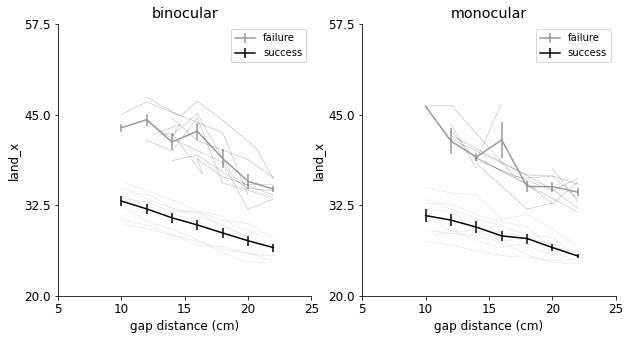

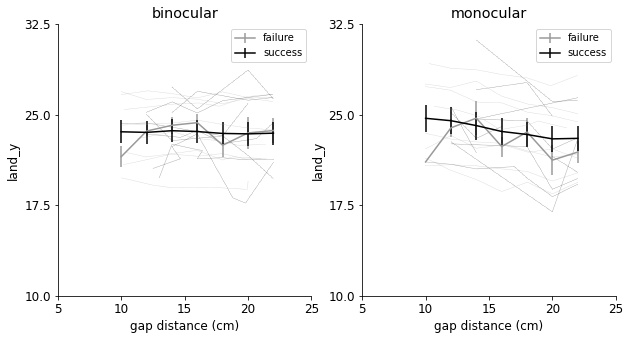

In [557]:
### this might not be useful
df_cond = df_jump_temp[(df_jump_temp['condition']=='control')|(df_jump_temp['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)

land_x, land_y = ([] for i in range(2))
for index,row in df_cond.iterrows():
    land_x.append(row['Top LEye x'][-1]/row['Top_pixpercm'])
    land_y.append(row['Top LEye y'][-1]/row['Top_pixpercm'])
df_cond['land_x'] = land_x
df_cond['land_y'] = land_y

variable = 'land_x'
condition = 'ocular'
am.plot_variable_vs_distance(df_cond,variable,condition,20,50,plot_params,False,[],suptitle='')

variable = 'land_y'
condition = 'ocular'
am.plot_variable_vs_distance(df_cond,variable,condition,10,30,plot_params,False,[],suptitle='')

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'WT'}, xlabel='gap distance (cm)', ylabel='land_y'>)

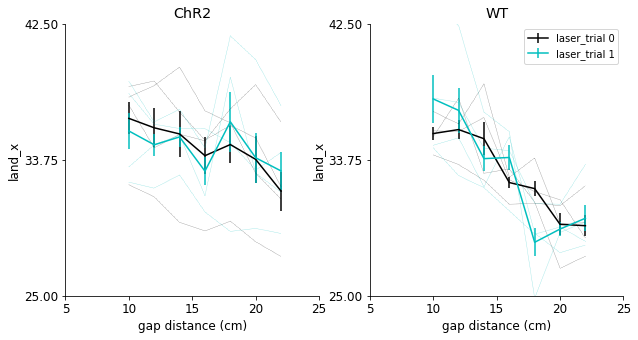

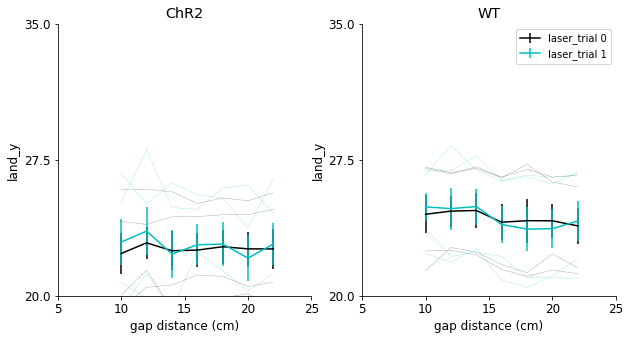

In [521]:
cond = 'controlopto'
df_cond = df_jump_temp[(df_jump_temp['condition']==cond)&(df_jump_temp['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)

land_x, land_y = ([] for i in range(2))
for index,row in df_cond.iterrows():
    land_x.append(row['Top LEye x'][-1]/row['Top_pixpercm'])
    land_y.append(row['Top LEye y'][-1]/row['Top_pixpercm'])
df_cond['land_x'] = land_x
df_cond['land_y'] = land_y

condition = 'expt_group'
manipulation = 'laser_trial'
variable = 'land_x'
am.plot_variable_vs_distance_manipulation(df_cond,variable,condition,manipulation,25,35,plot_params,False,[],suptitle='')

variable = 'land_y'
am.plot_variable_vs_distance_manipulation(df_cond,variable,condition,manipulation,20,30,plot_params,False,[],suptitle='')

# Look at distance jumped for binoc vs. monoc

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'binocular'}, xlabel='gap distance (cm)', ylabel='distance jumped (cm)'>,
        <AxesSubplot:title={'center':'monocular'}, xlabel='gap distance (cm)', ylabel='distance jumped (cm)'>],
       dtype=object))

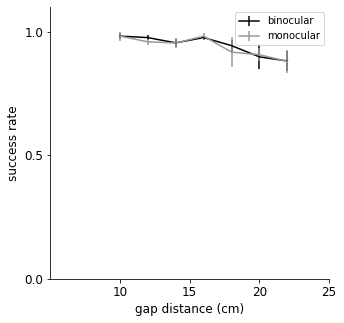

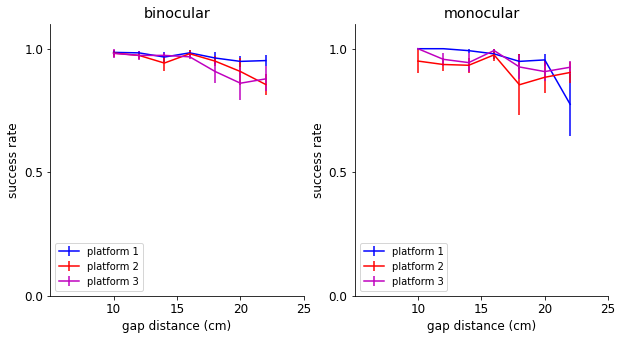

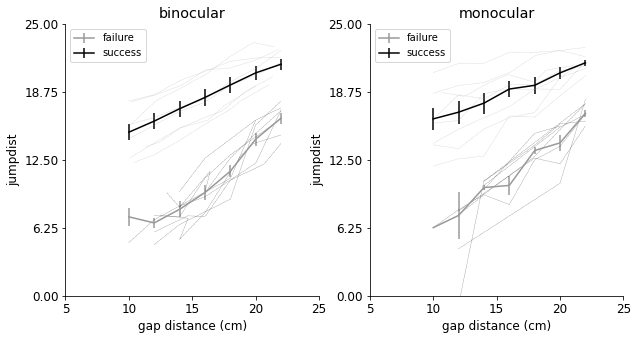

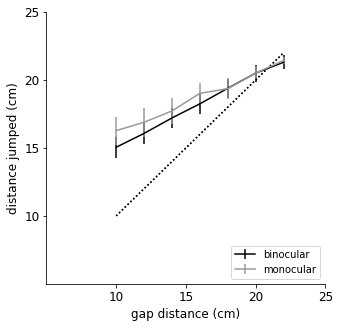

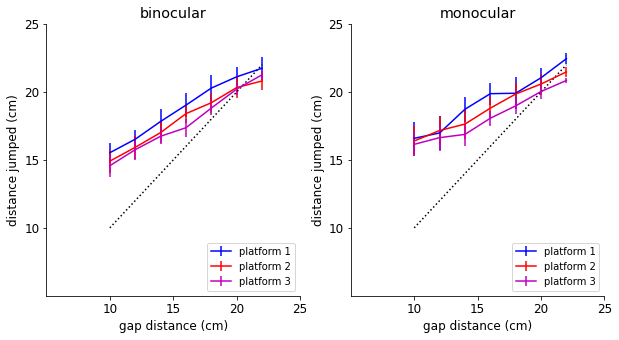

In [578]:
df_cond = df_jump_temp[(df_jump_temp['condition']=='control')|(df_jump_temp['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)

variable = 'jumpdist'
condition = 'ocular'
am.plot_performance(df_cond,condition,True,5,25,plot_params,False,[],suptitle='')
am.plot_performance_platforms(df_cond,condition,True,5,25,plot_params,False,[])
am.plot_variable_vs_distance(df_cond,variable,condition,0,25,plot_params,False,[],suptitle='')
am.plot_jumpdist(df_cond,condition,5,25,plot_params,False,[],suptitle='')
am.plot_jumpdist_platforms(df_cond,condition,5,25,plot_params,False,[])

# Analyze RMS head velocity (top)

In [442]:
dt=0.01
start_fr = -200
rms_vel = []
for index,row in df_jump_temp.iterrows():
    jump_fr = int(row['Top_Jump']-row['Top_Start'])

    x_trace = row['Top LEye x'][2:]
    y_trace = row['Top LEye y'][2:]
    x_trace = np.diff(x_trace[start_fr:jump_fr-2])/row['Top_pixpercm']
    y_trace = np.diff(y_trace[start_fr:jump_fr-2])/row['Top_pixpercm']

    vel = np.sqrt((x_trace)**2 + (y_trace)**2)/dt
    rms_vel.append(np.sqrt(np.mean(np.square(vel))))

df_jump_temp['rms_vel'] = rms_vel

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'1'}, xlabel='gap distance (cm)', ylabel='rms_vel'>)

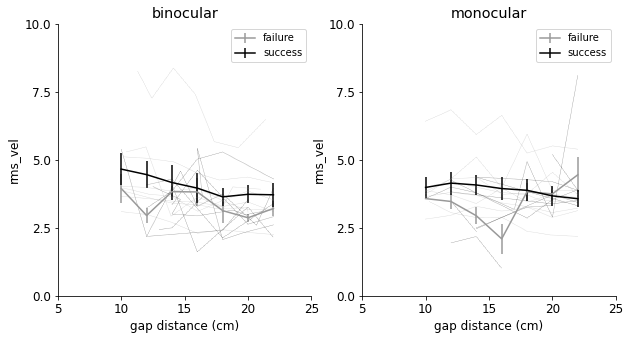

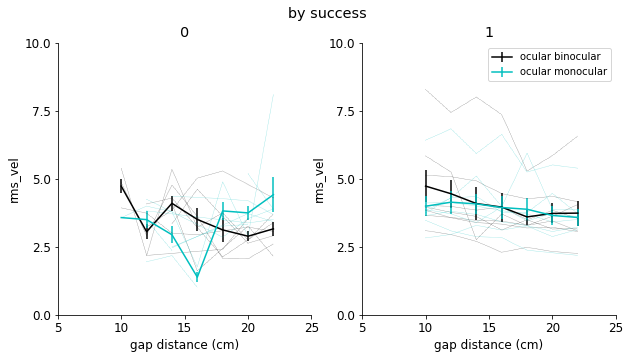

In [443]:
variable = 'rms_vel'
condition = 'ocular'

df_cond = df_jump_temp[(df_jump_temp['condition']=='control')|(df_jump_temp['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)
df_cond = df_cond[(df_cond['success']!=2)]
df_cond.reset_index(inplace=True,drop=True)
am.plot_variable_vs_distance(df_cond,variable,condition,0,10,plot_params,False,[],suptitle='')
am.plot_variable_vs_distance_manipulation(df_cond,variable,'success','ocular',0,10,plot_params,False,[],suptitle='by success')

In [3]:
np.unique(df_jump_temp['condition'])

array(['control', 'controlopto', 'suture', 'sutureopto'], dtype=object)

In [236]:


accuracy = []
l_thresh=0.99
for index,row in df_cond.iterrows():
    LandFR_x = np.nanmedian(row['Top LandFR x'][row['Top LandFR likelihood']>l_thresh])
    LandFL_x = np.nanmedian(row['Top LandFL x'][row['Top LandFL likelihood']>l_thresh])
    LandLEar = row['Top LEar x'][-1]
    accuracy.append((np.nanmean([LandFR_x,LandFL_x])-LandLEar)/row['Top_pixpercm'])
df_cond['accuracy'] = accuracy

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'WT laser_trial'}, xlabel='gap distance (cm)', ylabel='error (cm)'>)

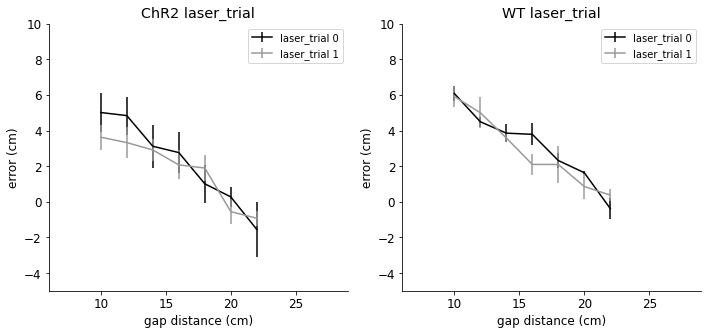

In [237]:
am.plot_jump_accuracy(df_cond,'expt_group','laser_trial',plot_params,False,[],'')

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'WT laser_trial'}, xlabel='gap distance (cm)', ylabel='success rate'>)

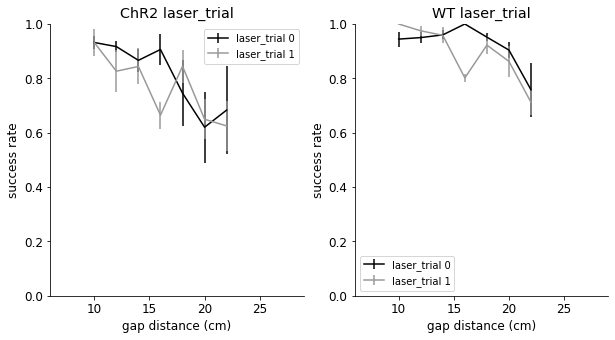

In [238]:
am.plot_performance_manipulation(df_cond,'expt_group','laser_trial',True,plot_params,False,[],'')

In [2]:
data_file = r'T:\jumping_revisions_analysis\df_decision_alldata_Side.h5'
df_all = pd.read_hdf(data_file,key='df')

In [4]:
trial_length = []
for index,row in df_all.iterrows():
    trial_length.append((row['Top_Jump']-row['Top_Start'])/100)
df_all['trial_length'] = trial_length

In [5]:
df_cond = df_all[(df_all['condition']=='control')|(df_all['condition']=='suture')]
df_cond.reset_index(inplace=True,drop=True)


(<Figure size 720x360 with 3 Axes>,
 <AxesSubplot:title={'center':'2'}, xlabel='gap distance (cm)', ylabel='trial_length'>)

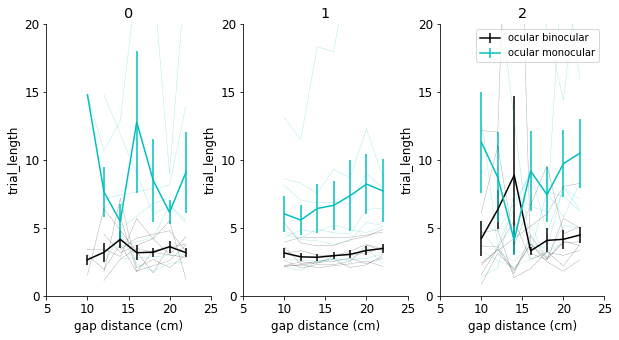

In [6]:
am.plot_variable_vs_distance_manipulation(df_cond,'trial_length','success','ocular',0,20,plot_params,False,[],suptitle='')

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'WT'}, xlabel='gap distance (cm)', ylabel='jumpdist'>)

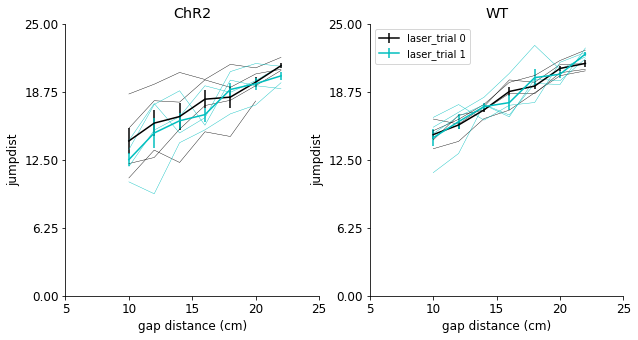

In [243]:
am.plot_variable_vs_distance_manipulation(df_cond[df_cond['success']==1],'jumpdist','expt_group','laser_trial',0,25,plot_params,False,[],suptitle='')

In [73]:
pdf_file = r'T:\jumping_revisions_analysis\monoc_opto_analysis.pdf'
pp = PdfPages(pdf_file)

#visualize all landing positions
im = np.ones((1080,1440,3))*255
im = im.astype('uint8')
dists = np.unique(df_cond['distance_DLC'])
anis = np.unique(df_cond['subject'])
laser_col = ['k','c']
laser_col_mean = ['b','m']
for ani in anis:
    df_ani = df_cond[(df_cond['subject']==ani)&(df_cond['success']==1)]
    df_ani.reset_index(inplace=True,drop=True)
    fig, axs = plt.subplots(2,int(np.ceil(len(dists)/2)),figsize=(4*int(np.ceil(len(dists)/2)),4*2))
    axs = axs.ravel()
    for d,dist in enumerate(dists):
        ax = axs[d]
        for laser in range(2):
            temp_df = df_ani[(df_ani['distance_DLC']==dist)&(df_ani['laser_trial']==laser)]
            temp_df.reset_index(inplace=True,drop=True)
            if laser==0:
                row = df_cond.iloc[np.where((df_cond['platform_DLC']==3)&(df_cond['distance_DLC']==dist))[0][0]] #find a trial w/platform 3
                vid_file = am.find(row['expdate'] + '_' + row['subject'] + '_' + row['condition'] + '_TOP_' + str(row['trial']-1) + '*.avi',expt_path)[0]
                frame,fps,frame_width,frame_height,ret = am.grab_vidframe(vid_file,100)
                ax.imshow(frame)
            #get landing positions
            xs = [i[-1] for i in temp_df['Top LEar x']]
            ys = [i[-1] for i in temp_df['Top LEar y']]
            #plot individual landing positions
            ax.scatter(xs,ys,c=laser_col[laser],marker='+',zorder=laser+1)
            #plot mean landing positions
            ax.scatter(np.mean(xs),np.mean(ys),c=laser_col_mean[laser],marker='o',zorder=laser+3)
        # ax.axis([0,1440,0,1080])
        ax.axis('off')
    axs[-1].axis('off')
    fig.suptitle(ani + ' ' + df_ani['expt_group'].iloc[0])
    pp.savefig(fig)
    plt.close(fig)


#visualize movements
for ani in anis:
    df_ani = df_cond[(df_cond['subject']==ani)&(df_cond['success']!=2)]
    df_ani.reset_index(inplace=True,drop=True)
    fig, axs = plt.subplots(2,int(np.ceil(len(dists)/2)),figsize=(4*int(np.ceil(len(dists)/2)),4*2))
    axs = axs.ravel()
    for d,dist in enumerate(dists):
        ax = axs[d]
        for laser in range(2):
            temp_df = df_ani[(df_ani['distance_DLC']==dist)&(df_ani['laser_trial']==laser)]
            temp_df.reset_index(inplace=True,drop=True)
            if laser==0:
                ax.imshow(im)
            # plot individual decision periods
            for index,row in temp_df.iterrows():
                ax.plot(row['Top LEar x'][:int(row['Top_Jump']-row['Top_Start'])],row['Top LEar y'][:int(row['Top_Jump']-row['Top_Start'])],
                '-',color=laser_col[laser],linewidth=0.5,alpha=0.4)
        # ax.axis([0,1440,0,1080])
        ax.axis('off')
    axs[-1].axis('off')
    fig.suptitle(ani + ' ' + df_ani['expt_group'].iloc[0])

    pp.savefig(fig)
    plt.close(fig)



#quanitfy head position histograms
maxy=10000
for ani in anis:
    df_ani = df_cond[(df_cond['subject']==ani)&(df_cond['success']!=2)]
    df_ani.reset_index(inplace=True,drop=True)
    fig, axs = plt.subplots(2,int(np.ceil(len(dists)/2)),figsize=(4*int(np.ceil(len(dists)/2)),4*2))
    axs = axs.ravel()
    for d,dist in enumerate(dists):
        ax = axs[d]
        trial_dur = []
        for laser in range(2):
            temp_df = df_ani[(df_ani['distance_DLC']==dist)&(df_ani['laser_trial']==laser)]
            temp_df.reset_index(inplace=True,drop=True)
            temp_arr = np.array([])
            for index,row in temp_df.iterrows():
                temp_arr = np.append(temp_arr,row['Top LEar y'][:int(row['Top_Jump']-row['Top_Start'])],axis=0)
            temp_arr.flatten()
            ax.hist(temp_arr,bins=np.arange(350,750,25),color=laser_col[laser],alpha=0.4,zorder=laser)
            # ax.plot([np.nanmean(temp_arr),np.nanmean(temp_arr)],[0,6000],':',color=laser_col[laser],linewidth=3,zorder=laser+2)
            ax.plot([np.nanmean(temp_arr)-np.nanstd(temp_arr),np.nanmean(temp_arr)+np.nanstd(temp_arr)],[maxy+laser*500,maxy+laser*500],'-',color=laser_col[laser],linewidth=3,zorder=laser+2)
            ax.plot(np.nanmean(temp_arr),maxy+laser*500,'o',color=laser_col[laser],linewidth=3,zorder=laser+2)
            try:
                trial_dur.append(temp_df['trial_length'].mean())
            except:
                trial_dur.append(0)
        ax.set_title('dur off=%0.1fs, on=%0.1fs' % (trial_dur[0],trial_dur[1]))
        ax.set_xlabel('head position (pix)')
        ax.set_ylabel('freq')
    fig.suptitle(ani + ' ' + df_ani['expt_group'].iloc[0])
    fig.tight_layout()
    pp.savefig(fig)
    plt.close(fig)

pp.close()

In [81]:
ani = 'PVCHA7RT'
df_ani = df_cond[(df_cond['subject']==ani)&(df_cond['success']==1)]
df_ani.reset_index(inplace=True,drop=True)
dist = 22
vals = np.where(df_ani['distance_DLC']==dist)[0]


In [82]:
xs = [i[-1] for i in df_ani['Top Nose x'].iloc[vals]]
ys = [i[-1] for i in df_ani['Top Nose y'].iloc[vals]]

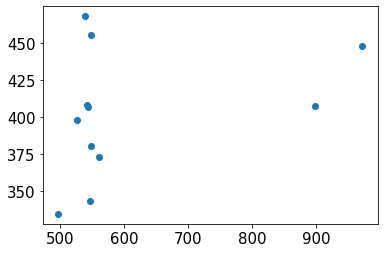

In [83]:
plt.plot(xs,ys,'o')

In [84]:
np.where(np.array(xs)>800)

(array([3, 9], dtype=int64),)

In [85]:
vals[3]

56

In [86]:
df_ani.iloc[3]

trial                                                                    4
success                                                                  1
platform                                                                 2
distance                                                                12
expdate                                                             022622
                                               ...                        
Top LandFR y             [235.08759, 235.08759, 236.24254, 236.61687, 2...
Top LandFR likelihood    [0.99993896, 0.99995124, 0.99998736, 0.9999907...
jumpdist                                                           13.1596
distance_DLC                                                            12
platform_DLC                                                             2
Name: 3, Length: 55, dtype: object

In [61]:
df_ani.iloc[167]

trial                                                                   23
success                                                                  1
platform                                                                 2
distance                                                                22
expdate                                                             030222
                                               ...                        
Top LandFR y             [228.78777, 228.78777, 229.29976, 229.457, 229...
Top LandFR likelihood    [0.9997893, 0.99985135, 0.9999411, 0.9999573, ...
jumpdist                                                           17.7044
distance_DLC                                                            22
platform_DLC                                                             2
Name: 167, Length: 55, dtype: object

In [62]:
row = df_ani.iloc[167]

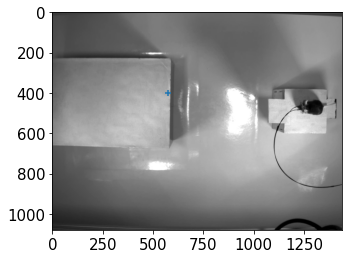

In [63]:
fig, ax = plt.subplots(1,1)
vid_file = am.find(row['expdate'] + '_' + row['subject'] + '_' + row['condition'] + '_TOP_' + str(row['trial']-1) + '*.avi',expt_path)[0]
frame,fps,frame_width,frame_height,ret = am.grab_vidframe(vid_file,100)
ax.imshow(frame)
#plot laser off trials
xs = row['Top Nose x'][-1]
ys = row['Top Nose y'][-1]
ax.scatter(xs,ys,marker='+')

In [43]:
df_ani[df_ani['distance_DLC']==22][['distance','distance_DLC','jumpdist']]

,distance,distance_DLC,jumpdist
13,22,22,22.047052
16,22,22,20.460836
17,22,22,22.837533
29,22,22,21.742900
33,20,22,20.809559
...,...,...,...
111,22,22,18.879799
126,22,22,25.709792
140,22,22,18.646792
144,22,22,21.897830


75 trials/animal


(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'1'}, xlabel='gap distance (cm)', ylabel='accuracy'>)

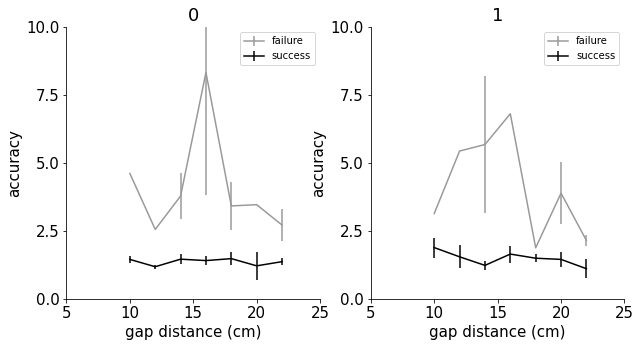

In [72]:
df = df_all[(df_all['condition']=='sutureopto')&(df_all['expt_group']=='ChR2')]
# df = data[(data['condition']=='sutureopto')&((data['expdate']=='031622')|(data['expdate']=='031722'))]
df.reset_index(inplace=True,drop=True)
print('%d trials/animal' % np.round(df.shape[0]/numAni))
am.plot_variable_vs_distance(df,'accuracy','laser_trial',0,10,plot_params,False,[],'')

In [81]:
df_jump.head()


,trial,success,platform,distance,expdate,subject,condition,laser_trial,fps,Top_pixpercm,Side_pixpercm,ocular,Top_Start,Top_Jump,Top_End,Side_Start,Side_Jump,Side_End,expt_group,Top LEar x,Top LEar y,Top LEar likelihood,jumpdist
0,1,1,2,18,012922,PVCHA7LN,control,0,99.97,21,35,binocular,26.0,360.0,380.0,26.0,360.0,380.0,ChR2,"[1063.5411376953125, 1063.5411376953125, 1063....","[525.462158203125, 525.462158203125, 525.46215...","[0.0006798803806304932, 0.0005106031894683838,...",17.741888
1,2,1,1,18,012922,PVCHA7LN,control,0,99.97,21,35,binocular,34.0,284.0,304.0,34.0,284.0,304.0,ChR2,"[1018.3106079101562, 1018.3106079101562, 1018....","[483.89080810546875, 483.89080810546875, 483.8...","[0.0005124415038153529, 0.002934798365458846, ...",20.555687
2,3,2,1,16,012922,PVCHA7LN,control,0,99.97,21,35,binocular,42.0,242.0,266.0,42.0,242.0,266.0,ChR2,"[1085.521240234375, 1085.521240234375, 1085.52...","[474.64044189453125, 474.64044189453125, 474.6...","[0.0004901314969174564, 0.00045892890193499625...",-0.345802
3,4,1,1,20,012922,PVCHA7LN,control,0,99.97,21,35,binocular,45.0,499.0,521.0,44.0,498.0,520.0,ChR2,"[1018.4013061523438, 1018.4013061523438, 1018....","[470.3409118652344, 470.3409118652344, 470.340...","[0.0034327181056141853, 0.00067335698986426, 0...",20.934986
4,5,1,1,22,012922,PVCHA7LN,control,0,99.97,21,35,binocular,46.0,240.0,262.0,46.0,240.0,262.0,ChR2,"[1019.0136108398438, 1019.0136108398438, 1019....","[509.6716613769531, 509.6716613769531, 509.671...","[0.0208955779671669, 0.0004516159533523023, 0....",22.344273


In [ ]:
# load data if necessary
h5file = r'T:\revision_experiments_basedf.h5'
df = pd.read_hdf(h5file)

# set the duration of the window for individual movements
pwin = 0.25 #half the movement duration window desired
# metric = 'velocity'
metric = 'position'


mvmnt_data = am.add_movements_to_df(df,pwin,['Side','Top'],metric)
print('finished loading data and extracting movements')

# save the data
mvmnt_file = r'T:\revision_experiments_mvmnts_%sms_%s.h5' % (int(pwin*1000),metric)
mvmnt_data.to_hdf(mvmnt_file,key='df',mode='w')
print('finished saving data!')

In [ ]:
# set the duration of the window for individual movements
pwin = 0.25 #half the movement duration window desired
metric = 'velocity'
# nclusts = np.arange(3,16) #range of cluster numbers you want
n_guess = 100 #int(nclusts[-1])
# hthresh = 0.01 #min threshold for dendrogram to select the lastp number of clusters
# Load unclustered data
start = time.time()
mvmnt_file = r'T:\revision_experiments_mvmnts_%sms_%s.h5' % (int(pwin*1000),metric)
df_all = pd.read_hdf(mvmnt_file)
print('loaded data from file in %0.1f seconds' % (time.time()-start))

In [ ]:
## Set up PDF file if save_pdf=True
if save_pdf:
    pdf_file = mvmnt_file[:-3] + '_temp.pdf'
    pp = PdfPages(pdf_file)
else:
    pp=[]

# Get data into UMAP format
start = time.time()
data, xeye, yeye, mov_rel_jump, mov_rel_start, windows = am.data_to_umap(df_all,'Side')
print('added data to UMAP in %0.1f seconds' % (time.time()-start))
# data, xeye, yeye, xnose, ynose, theta, xnose, ynose, mov_rel_jump, mov_rel_start, windows = am.data_to_umap(df_all,'Side')

# Run PCA and K-means clustering and run UMAP embedding on PCA
pca_components = 10
start = time.time()
pca, reduced_data, kmeans, cluster_data, n_k, fig, ax = am.run_pca_kmeans(data,pca_components,save_pdf,pp)
print('finished PCA in %0.1f seconds' % (time.time()-start))

# Create the labels for the UMAP of PCA data
start = time.time()
labels_all, embedding = am.create_umap_labels(df_all,'Side',kmeans,reduced_data,xeye,yeye,windows,mov_rel_jump,mov_rel_start)
print('created UMAP labels in %0.1f seconds' % (time.time()-start))



# Perform hierarchical clustering
start = time.time()
Z = am.hierarchical_dendrogram(reduced_data,n_guess)
print('finished initial hierarchical clustering in %0.1f seconds' % (time.time()-start))


plt.figure()
last = Z[-50:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev,label='1st deriv')
acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev,label='2nd deriv')
plt.ylabel('distance between leaves')
plt.legend(fontsize=8)
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
plt.title("ideal clusters: %d" % k)

# for i in range(11):
#     plt.plot([0,500],[i,i],'k:')

In [ ]:
# ### clustering parameters
nclust = 6
hthresh = 11

# for nc,nclust in enumerate(nclusts):

# print('doing %d clusters (%d/%d total)' % (nclust,(nc+1),len(nclusts)))

start = time.time()
labels_clust, n_k, fig1, fig2 = am.hierarchical_clustering(labels_all,'Side',reduced_data,Z,hthresh,int(nclust),plot_params,save_pdf,pp)
print('finished hierarchical clustering in %0.2f seconds' % (time.time()-start))

# UMAP of PCA with variables mapped onto points with colors (kmeans, hierarchical)
fig, ax = am.plot_UMAP_labels(labels_clust,'kmeans',plot_params,save_pdf,pp)
fig, ax = am.plot_UMAP_labels(labels_clust,'hclusters',plot_params,save_pdf,pp)


# Order the clusters by variance (high to low)
labels_clust = am.order_clusters_by_variance(labels_clust,'Side','kmeans')
labels_clust = am.order_clusters_by_variance(labels_clust,'Side','hclusters')

# Calculate movement amplitudes
labels_clust = am.get_movement_amplitudes(labels_clust,'Side')

# Interactive UMAP visualization (optional)
if show_UMAP:
    p = am.play_fn(x,y,theta, embedding, pdf_file[:-4] + '.hmtl')

# Save the df and labels
df_pickle = mvmnt_file[:-3] + '_df.h5'
labels_pickle = mvmnt_file[:-3] + '_labels.h5'
df_all.to_hdf(df_pickle,key='df',mode='w')
labels_all.to_hdf(labels_pickle,key='df',mode='w')

# Close the clustering PDF
if save_pdf:
    pp.close()
    try:
        os.rename(os.path.normpath(pdf_file),
                  os.path.normpath(pdf_file[:-9] + '_normpca_clustering_%dclusts.pdf' % (n_k)))
        print('Saved clustering PDF')
    except:
        os.remove(os.path.normpath(pdf_file[:-9] + '_normpca_clustering_%dclusts.pdf' % (n_k)))
        os.rename(os.path.normpath(pdf_file),
                  os.path.normpath(pdf_file[:-9] + '_normpca_clustering_%dclusts.pdf' % (n_k)))
        print('Saved clustering PDF')

print('finished clustering %d movements' % n_k)

#     ### manually load clustered data
#     n_k = 2 #number of clusters in the dataset
#     df_pickle = mvmnt_file[:-3] + '_df_%dclusts.h5' % n_k
#     labels_pickle = mvmnt_file[:-3] + '_labels_%dclusts.h5' % n_k
#     df_all = pd.read_hdf(df_pickle)
#     labels_all = pd.read_hdf(labels_pickle)
#     df_all = df_all.astype({'success': 'int32'})
# df_all[df_all['success']==2] = df_all[df_all['success']==2].replace(2,0)
# df_all.loc[:,'jumpdist'] = df_all['jumpdist'].astype('float')
# labels_all[labels_all['success']==2] = labels_all[labels_all['success']==2].replace(2,0)

In [ ]:
df_clust = df_all.copy()
df_clust = am.get_jump_accuracy(df_clust)
labels_clust = am.get_movement_amplitudes_mm(labels_clust,'Side')
labels_clust.loc[:,'jumpdist'] = labels_clust['jumpdist'].astype('float')

###### Baseline group analysis
base_df = df_clust.copy()
base_df = base_df[base_df['laser_trial']=='laser off']
base_df.reset_index(inplace=True,drop=True)
base_df[base_df['condition']=='opto suture'] = base_df[base_df['condition']=='opto suture'].replace('opto suture','suture')
base_labels = labels_clust.copy()
base_labels = base_labels[base_labels['laser_trial']=='laser off']
base_labels.reset_index(inplace=True,drop=True)
base_labels[base_labels['condition']=='opto suture'] = base_labels[base_labels['condition']=='opto suture'].replace('opto suture','suture')


# cluster_key = 'hclusters'
cluster_key = 'kmeans'
condition = 'ocular'
side = 'Side'


## Set up group plot PDF file if save_pdf=True
if save_pdf:
    pdf_file = mvmnt_file[:-3] + '_baseline_group_plots_normpca_%d_%sclusts.pdf' % (len(np.unique(base_labels[cluster_key])),cluster_key)
    pp = PdfPages(pdf_file)
else:
    pp=[]


# Analyze movements from kmeans clustering of PCA data (group, individual)
fig, ax = am.plot_movement_clusters(base_df,base_labels,side,cluster_key,condition,plot_params,save_pdf,pp)
fig, ax = am.plot_cluster_freq(base_df,base_labels,cluster_key,condition,plot_params,save_pdf,pp)
fig, ax = am.plot_movement_timing(base_labels,side,cluster_key,condition,-5,0.5,pwin,plot_params,save_pdf,pp)

for cluster_num in range(len(np.unique(base_labels[cluster_key]))):
    fig, ax = am.plot_movement_trace_distance(base_labels,side,cluster_num,cluster_key,condition,plot_params,save_pdf,pp)
    base_df = am.label_bob_frequency(base_df,base_labels,cluster_key,cluster_num)
    fig, ax = am.plot_performance_bob_freq(base_df,condition,'bob_freq',1,plot_params,save_pdf,pp,suptitle='cluster %d' % cluster_num)
    fig, ax = am.plot_variable_vs_distance(base_df,'bob_freq',condition,0,6,plot_params,save_pdf,pp,suptitle='cluster %d' % cluster_num)
    fig, ax = am.plot_movement_amplitudes(base_labels,cluster_num,cluster_key,'ocular',plot_params,save_pdf,pp)

### create lists of platform widths and gap distances to get retinal image size
# pfs = np.around(np.array([4,8,12])*2.54,decimals=1)
# ds = np.around(np.arange(8,28,4),decimals=1)
# ris, fig, ax = am.make_ris_table(pfs,ds,save_pdf,pp)

fig, ax = am.plot_performance(base_df,condition,1,5,25,plot_params,save_pdf,pp)
fig, ax = am.plot_jump_accuracy(base_df,condition,'success',plot_params,save_pdf,pp,'accuracy vs. success')
fig, ax = am.plot_jumpdist(base_df,condition,5,25,plot_params,save_pdf,pp)
fig, ax = am.plot_performance_platforms(base_df,condition,1,5,25,plot_params,save_pdf,pp)
# fig, ax = am.plot_ris_distance(base_df,condition,ris,plot_params,save_pdf,pp)
fig, ax = am.plot_jumpdist_platforms(base_df,condition,5,25,plot_params,save_pdf,pp)

### close the group PDF
try:
    pp.close()
except:
    pass

print('finished plotting data for %d %s clusters!' % (len(np.unique(base_labels[cluster_key])),cluster_key))
# print('finished analysis for animal %d/%d' % (aninum+1,len(anis)))


### old

# fig, ax = am.plot_movement_timing(base_labels,'Side','hclusters','ocular',plot_params,save_pdf,pp)
# base_df = am.label_any_bob_trials(base_df,base_labels,'hclusters')
# fig, ax = am.plot_performance_vs_movement(base_df,base_labels,' any mvmt','hclusters','ocular',plot_params,save_pdf,pp)

# for cluster_num in range(n_k):
#     fig, ax = am.calculate_movement_frequency(base_df,base_labels,cluster_num,'hclusters','ocular',plot_params,save_pdf,pp)
#     fig, ax = am.plot_movement_amplitudes(base_labels,cluster_num,'hclusters','ocular',plot_params,save_pdf,pp)
#     fig, ax = am.plot_yamps_mm(base_labels,cluster_num,'hclusters','ocular',1,4,plot_params,save_pdf,pp)
#     fig, ax = am.plot_visangles(base_labels,cluster_num,'hclusters','ocular',1,plot_params,save_pdf,pp)
#     fig, ax = am.plot_performance_vs_movement(base_df,base_labels,cluster_num,'hclusters','ocular',plot_params,save_pdf,pp)
#     base_df = am.label_bob_trials(base_df,base_labels,'hclusters',cluster_num)
#     fig, ax = am.plot_jump_accuracy(base_df,'ocular','bob_trial',cluster_num,plot_params,save_pdf,pp)

In [ ]:
pwin = 0.25 #half the movement duration window desired
metric = 'velocity'
# metric = 'position'
mvmnt_file = r'T:\variable_platform_mvmnts_%sms_%s.h5' % (int(pwin*1000),metric)
df_all = pd.read_hdf(mvmnt_file)
base_df = df_all.copy()
base_df = base_df[base_df['laser_trial']=='laser off']
base_df.reset_index(inplace=True,drop=True)
base_df[base_df['condition']=='opto suture'] = base_df[base_df['condition']=='opto suture'].replace('opto suture','suture')

In [ ]:
condition = 'ocular'

fig, axs, array = am.plot_fraction_success(base_df,condition,plot_params['cond_col'],False,pp,'all subjects')


anis = np.unique(base_df['subject'])
dists = np.unique(base_df['distance'])
conds = np.unique(base_df[condition])
sucs = np.unique(base_df['success'])
suc_lab = ['failure','success','abort']


for s,suc in enumerate(sucs):
    anova_df = pd.DataFrame(columns=['distance',condition,'success'])
    for d,dist in enumerate(dists):
        for c,cond in enumerate(conds):
            temp_df = pd.DataFrame(columns=['distance',condition,'success'])
            temp_df['distance']  = pd.Series(np.repeat(dist,len(anis)))
            temp_df[condition] = pd.Series(np.repeat(cond,len(anis)))
            temp_df['success'] = array[:,d,c,s]
            anova_df = pd.concat([anova_df,temp_df],axis=0)
    #print anova results
    model = ols('success ~ C(distance) + C(ocular) + C(distance):C(ocular)', data=anova_df).fit()
    print(suc_lab[s])
    print(sm.stats.anova_lm(model, typ=2))
    print('')

719 trials/animal


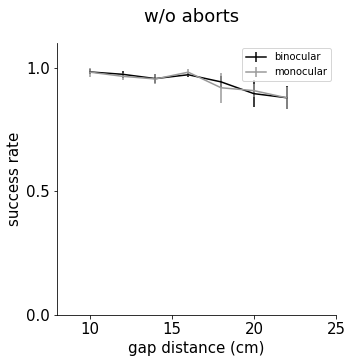

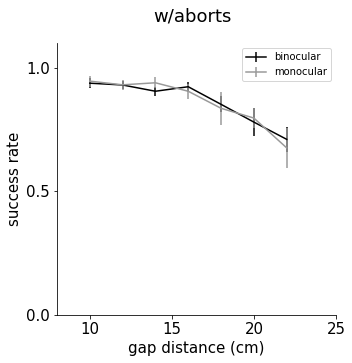

In [3]:
df = data[(data['condition']=='control')|(data['condition']=='suture')]
df.reset_index(inplace=True,drop=True)
print('%d trials/animal' % np.round(df.shape[0]/numAni))
# df.head()

fig, ax = am.plot_performance(df,'ocular',False,8,24,plot_params,False,[],suptitle='w/o aborts')
fig, ax = am.plot_performance(df,'ocular',True,8,24,plot_params,False,[],suptitle='w/aborts')

237 trials/animal


(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'WT laser_trial'}, xlabel='gap distance (cm)', ylabel='success rate'>)

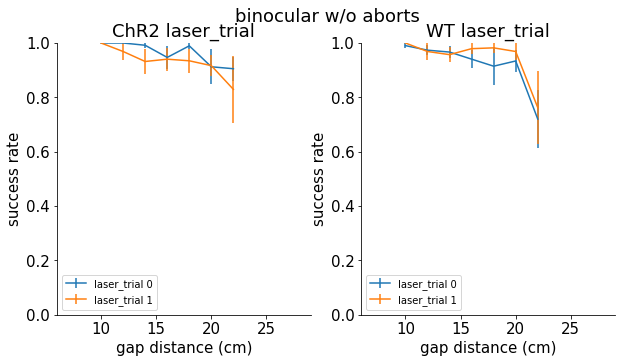

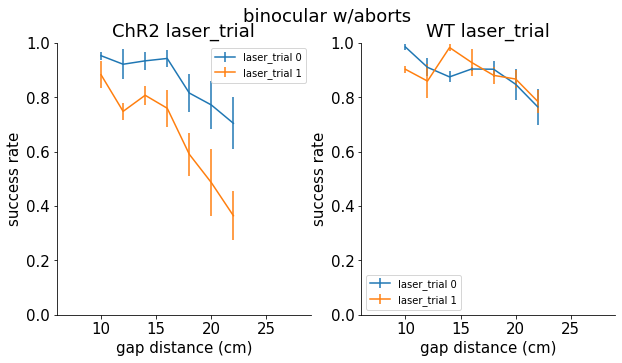

In [4]:
df = data[(data['condition']=='controlopto')]
df.reset_index(inplace=True,drop=True)
print('%d trials/animal' % np.round(df.shape[0]/numAni))
# df.head()

am.plot_performance_manipulation(df,'expt_group','laser_trial',False,plot_params,False,[],'binocular w/o aborts')
am.plot_performance_manipulation(df,'expt_group','laser_trial',True,plot_params,False,[],'binocular w/aborts')

223 trials/animal


(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'WT laser_trial'}, xlabel='gap distance (cm)', ylabel='success rate'>)

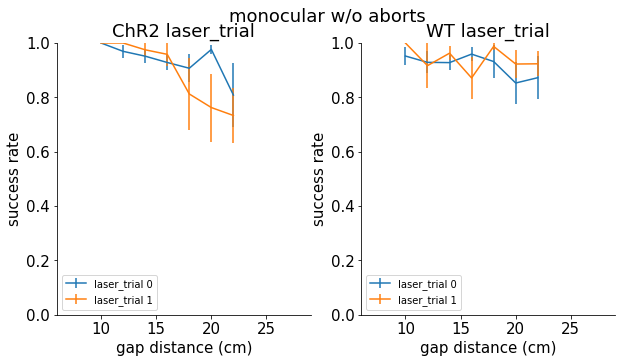

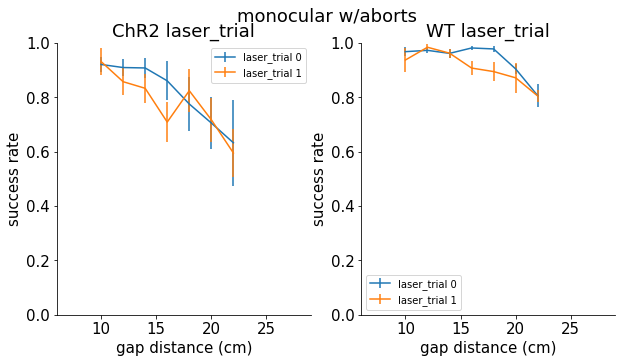

In [5]:
df = data[(data['condition']=='sutureopto')]
# df = data[(data['condition']=='sutureopto')&((data['expdate']=='031622')|(data['expdate']=='031722'))]
df.reset_index(inplace=True,drop=True)
print('%d trials/animal' % np.round(df.shape[0]/numAni))
# df.head()

am.plot_performance_manipulation(df,'expt_group','laser_trial',False,plot_params,False,[],'monocular w/o aborts')
am.plot_performance_manipulation(df,'expt_group','laser_trial',True,plot_params,False,[],'monocular w/aborts')